Problem Statement:

    Help filter good leads for various banking products given the training data.

In [1]:
import findspark
findspark.init('C:\spark-3.2.1-bin-hadoop3.2')
from pyspark.sql import SparkSession
import pandas as pd



In [2]:
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.sql.functions import mean,col,split, col, regexp_extract, when, lit
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import QuantileDiscretizer

In [3]:
#To create SparkSession in Python, we need to use the builder() method and calling getOrCreate() method
spark=SparkSession.builder.appName('Dataframe').getOrCreate()
spark

In [4]:
## read the dataset
df_pyspark=spark.read.option('header','true').csv('train.csv',inferSchema=True)
df=pd.read_csv('train.csv')

The training dataset (see attached files) includes:

    ID - Unique identifier

    Gender - Gender of the applicant

    Age - Age of the applicant

    Region_Code - Region of the applicant

    Occupation - Occupation of the applicant

    Channel_Code - Channel of communication

    Vintage - relationship in months with the bank

    Credit_Product - The product that was recommended

    Avg_Account_Balance - Average account balance

    Is_Active - Binary flag for activity

    Is_Lead - Target variable

# Statistical analysis

In [5]:
#Visualy seeing the data
df_pyspark.show()

+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+
|      ID|Gender|Age|Region_Code|   Occupation|Channel_Code|Vintage|Credit_Product|Avg_Account_Balance|Is_Active|Is_Lead|
+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+
|FFLQKHYH|Female| 41|      RG251|Self_Employed|          X1|     15|            No|             450455|       No|      0|
|DQEKJPCZ|  Male| 50|      RG279|Self_Employed|          X2|     79|           Yes|            1343303|      Yes|      0|
|JSVL7FLG|  Male| 39|      RG279|Self_Employed|          X2|     20|          null|             461678|       No|      1|
|6M9GSDXZ|Female| 38|      RG273|Self_Employed|          X2|     19|          null|             549227|      Yes|      1|
|4F9MRSPP|Female| 47|      RG280|Self_Employed|          X2|     75|           Yes|             756704|       No|      0|
|PNGZMCOK|  Male| 27|   

In [6]:
df_pyspark.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
ID,149999,None,None,222A8XWS,ZZZZ6MXS
Gender,149999,None,None,Female,Male
Age,149999,43.85046566977113,14.836576467854858,23,85
Region_Code,149999,None,None,RG250,RG284
Occupation,149999,None,None,Entrepreneur,Self_Employed
Channel_Code,149999,None,None,X1,X4
Vintage,149999,46.96040640270935,32.32911156594882,7,135
Credit_Product,132036,None,None,No,Yes
Avg_Account_Balance,149999,1129887.234834899,854932.9636765522,20790,10007678


1. ID has 1499999 unique values, that is all the values are unique and hence can be dropped
2. There is large difference seen between mean and 50% in AVG Account balance, hence showing presence of outliers
3. There is small difference between meana and 50% in Vintage, hence showing presence of little outliers
4. Gender,Credit product and is Active has 2 unique values in their column
5. Outliers can be seen in target variable as well, however the cause of it will be later analysed and steps taken in regard to it

In [7]:
df_pyspark.columns

['ID',
 'Gender',
 'Age',
 'Region_Code',
 'Occupation',
 'Channel_Code',
 'Vintage',
 'Credit_Product',
 'Avg_Account_Balance',
 'Is_Active',
 'Is_Lead']

These are the column names

In [8]:
df["Is_Lead"].unique()

array([0, 1], dtype=int64)

Target has 0 and 1, hence it is a classification problem /


In [9]:
#unique values of 
print("\nUnique values of Region code is\n",df["Region_Code"].unique())
print("\nUnique values of Gender is\n",df["Gender"].unique())
print("\nUnique values of Occupation is\n",df["Occupation"].unique())
print("\nUnique values of Channel_Code is\n",df["Channel_Code"].unique())
print("\nUnique values of Credit_Product is\n",df["Credit_Product"].unique())
print("\nUnique values of Is_Active is\n",df["Is_Active"].unique())


Unique values of Region code is
 ['RG251' 'RG279' 'RG273' 'RG280' 'RG254' 'RG283' 'RG253' 'RG272' 'RG268'
 'RG271' 'RG260' 'RG284' 'RG261' 'RG275' 'RG257' 'RG277' 'RG266' 'RG282'
 'RG252' 'RG269' 'RG258' 'RG270' 'RG263' 'RG255' 'RG267' 'RG265' 'RG281'
 'RG259' 'RG276' 'RG274' 'RG256' 'RG264' 'RG250' 'RG262' 'RG278']

Unique values of Gender is
 ['Female' 'Male']

Unique values of Occupation is
 ['Self_Employed' 'Salaried' 'Other' 'Entrepreneur']

Unique values of Channel_Code is
 ['X1' 'X2' 'X3' 'X4']

Unique values of Credit_Product is
 ['No' 'Yes' nan]

Unique values of Is_Active is
 ['No' 'Yes']


In [10]:
### Check the schema
df_pyspark.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Region_Code: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Channel_Code: string (nullable = true)
 |-- Vintage: integer (nullable = true)
 |-- Credit_Product: string (nullable = true)
 |-- Avg_Account_Balance: integer (nullable = true)
 |-- Is_Active: string (nullable = true)
 |-- Is_Lead: integer (nullable = true)



In [11]:
df_pyspark.dtypes

[('ID', 'string'),
 ('Gender', 'string'),
 ('Age', 'int'),
 ('Region_Code', 'string'),
 ('Occupation', 'string'),
 ('Channel_Code', 'string'),
 ('Vintage', 'int'),
 ('Credit_Product', 'string'),
 ('Avg_Account_Balance', 'int'),
 ('Is_Active', 'string'),
 ('Is_Lead', 'int')]

There are 7 string columns-ID,Gender,Region_code,occupation,Channel_code,Credit_Product,Is_Active

There are 3 integer columns-Age,Avg_Account_Balance,Is_Lead

**Gender**

In [12]:
df_pyspark.groupBy("Gender").mean().show()

+------+-----------------+------------------+------------------------+------------------+
|Gender|         avg(Age)|      avg(Vintage)|avg(Avg_Account_Balance)|      avg(Is_Lead)|
+------+-----------------+------------------+------------------------+------------------+
|Female|41.41399712247115| 41.83970989811199|       1108083.453063981|  0.20346771588807|
|  Male| 45.8771814129572|51.219930390181354|      1148024.1682359406|0.2663491481956402|
+------+-----------------+------------------+------------------------+------------------+



In [13]:
df_pyspark.groupBy("Gender").count().show()

+------+-----+
|Gender|count|
+------+-----+
|Female|68114|
|  Male|81885|
+------+-----+



1. Females average age is 41, there average vintage is 41, average account balance is 11,08,083 
2. Females average age is 41, there average vintage is 41, average account balance is 11,08,083 
3. Total female is 68,114 and male is 81,885

**Region Code**

In [14]:
df_pyspark.groupBy("Region_Code").mean().show()

+-----------+------------------+------------------+------------------------+-------------------+
|Region_Code|          avg(Age)|      avg(Vintage)|avg(Avg_Account_Balance)|       avg(Is_Lead)|
+-----------+------------------+------------------+------------------------+-------------------+
|      RG254|  43.4981509548348|46.792543194907545|      1402474.5591997574| 0.2121855107608366|
|      RG277| 41.76213286272532| 42.45909491995462|       983883.8957519224|0.22866506996092273|
|      RG255| 42.67739340305712| 43.06918744971842|       876667.5285599356| 0.2244569589702333|
|      RG271| 36.07120418848167| 32.90680628272251|       749684.0356020943|0.18429319371727748|
|      RG262|41.431588613406795| 41.99357208448117|      1201266.4839302113| 0.1763085399449036|
|      RG272| 43.75785869903517| 42.92934951758481|       887023.9296607532|0.22253345782757547|
|      RG275| 38.54791029561672|  35.5249745158002|       855476.6671763507|0.16972477064220184|
|      RG283|   49.09937611408

In [15]:
df_pyspark.groupBy("Region_Code").count().show()

+-----------+-----+
|Region_Code|count|
+-----------+-----+
|      RG254|16495|
|      RG277| 7933|
|      RG255| 1243|
|      RG271|  955|
|      RG262| 1089|
|      RG272| 3213|
|      RG275| 1962|
|      RG283|17952|
|      RG261| 4687|
|      RG263| 2258|
|      RG256| 1789|
|      RG273| 2689|
|      RG250| 1491|
|      RG265|  944|
|      RG282| 3540|
|      RG252| 2565|
|      RG251| 3607|
|      RG269| 4792|
|      RG260| 1907|
|      RG281| 3134|
+-----------+-----+
only showing top 20 rows



These are the count of the region codes

**OCCUPATION**

In [16]:
df_pyspark.groupBy("Occupation").count().show()

+-------------+-----+
|   Occupation|count|
+-------------+-----+
|Self_Employed|61494|
|     Salaried|44048|
|        Other|42807|
| Entrepreneur| 1650|
+-------------+-----+



In [17]:
df_pyspark.groupBy("Occupation").mean().show()

+-------------+------------------+------------------+------------------------+-------------------+
|   Occupation|          avg(Age)|      avg(Vintage)|avg(Avg_Account_Balance)|       avg(Is_Lead)|
+-------------+------------------+------------------+------------------------+-------------------+
|Self_Employed|46.551403388948515|55.521660649819495|      1133498.4156340456|0.27583178846716755|
|     Salaried|30.902651652742463|26.351752633490737|      1034083.4241736288|0.16166454776607336|
|        Other|53.141892681103556|54.983133599644916|      1212674.1004975822|0.24505337912023734|
| Entrepreneur| 47.78727272727273| 69.91515151515152|      1405064.7751515151| 0.6642424242424242|
+-------------+------------------+------------------+------------------------+-------------------+



1. The average age is highest for other occupations
2. Highest vintage is for entrpreneur, hence its seen highest number of years who have relationship with the bank are Entrepreneurs.
3. Entrepreneurs are seen to have average highest account balance
4. However highest leads for the banks are the Self Employed

**Channel_Code**

In [18]:
df_pyspark.groupBy("Channel_Code").count().show()

+------------+-----+
|Channel_Code|count|
+------------+-----+
|          X4| 3303|
|          X1|63276|
|          X3|42005|
|          X2|41415|
+------------+-----+



In [19]:
df_pyspark.groupBy("Channel_Code").mean().show()

+------------+------------------+------------------+------------------------+-------------------+
|Channel_Code|          avg(Age)|      avg(Vintage)|avg(Avg_Account_Balance)|       avg(Is_Lead)|
+------------+------------------+------------------+------------------------+-------------------+
|          X4|44.848925219497424| 12.46745382985165|       982832.0572207085|0.24492885255828034|
|          X1| 32.28666477021304|25.311192237183135|      1029674.0010746571|0.09270497503002718|
|          X3|  54.7330555886204| 74.76986073086537|      1277314.5712653256|0.36600404713724555|
|          X2| 50.40098997947604| 54.58251841120367|       1145198.850537245| 0.3288663527707352|
+------------+------------------+------------------+------------------------+-------------------+



**Credit_Product**

In [20]:
df_pyspark.groupBy("Credit_Product").count().show()

+--------------+-----+
|Credit_Product|count|
+--------------+-----+
|          null|17963|
|            No|88136|
|           Yes|43900|
+--------------+-----+



In [21]:
df_pyspark.groupBy("Credit_Product").mean().show()

+--------------+-----------------+------------------+------------------------+-------------------+
|Credit_Product|         avg(Age)|      avg(Vintage)|avg(Avg_Account_Balance)|       avg(Is_Lead)|
+--------------+-----------------+------------------+------------------------+-------------------+
|          null|51.49228970661916|  66.4835495184546|      1220953.9594722486| 0.8521405110504927|
|            No|40.79389806662431| 40.58357538349823|      1080341.6110783336|0.07396523554506672|
|           Yes| 46.8601138952164|51.774396355353076|      1192095.0143507973|0.31533029612756264|
+--------------+-----------------+------------------+------------------------+-------------------+



Credit Product is the product was recommended or not
1. It was recommended only 1/3rd of times
2. When product was recommended by bank, it was converted to lead more number of times

**Is_Active**

In [22]:
df_pyspark.groupBy("Is_Active").count().show()

+---------+-----+
|Is_Active|count|
+---------+-----+
|       No|91564|
|      Yes|58435|
+---------+-----+



In [23]:
df_pyspark.groupBy("Is_Active").mean().show()

+---------+-----------------+-----------------+------------------------+-------------------+
|Is_Active|         avg(Age)|     avg(Vintage)|avg(Avg_Account_Balance)|       avg(Is_Lead)|
+---------+-----------------+-----------------+------------------------+-------------------+
|       No|41.26714647678127|41.56079900397536|       1076579.990596741| 0.2091105674719322|
|      Yes|47.89836570548473|55.42125438521434|      1213416.3614101138|0.28274150765808165|
+---------+-----------------+-----------------+------------------------+-------------------+



1. customer was active 58435 times and not active 91564
2. Account balance was higher for those who were active
3. More lead came from customers who were active

# Graphical analysis of Data

<AxesSubplot:title={'center':'count (target)'}>

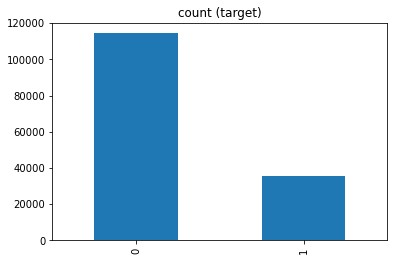

In [24]:
df=df_pyspark.toPandas()
df['Is_Lead'].value_counts().plot(kind='bar', title='count (target)')

In [25]:
#balancing class
df=df_pyspark.toPandas()

# class count
class_count_0, class_count_1 = df['Is_Lead'].value_counts()

#Separate class
class_0 = df[df['Is_Lead'] == 1]
class_1 = df[df['Is_Lead'] == 0]

print('class No/0:', class_0.shape)
print('class Yes/1:', class_1.shape)

class No/0: (35669, 11)
class Yes/1: (114330, 11)


**1.Relationship between categorical features and label**

--------- Gender vs Is_Lead---------------------------------------------------------------------------------


Gender
Male      81885
Female    68114
Name: Gender, dtype: int64




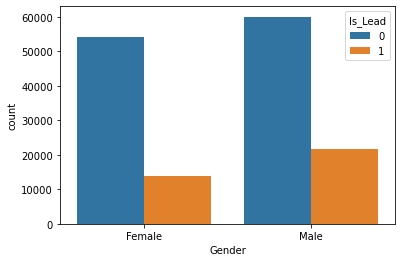

<Figure size 432x216 with 0 Axes>

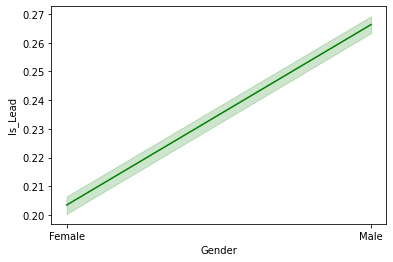

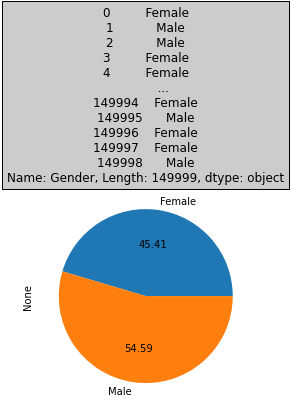



--------- Region_Code vs Is_Lead---------------------------------------------------------------------------------


Region_Code
RG268    21914
RG283    17952
RG254    16495
RG284    11793
RG277     7933
RG280     7785
RG269     4792
RG270     4691
RG261     4687
RG257     3741
RG251     3607
RG282     3540
RG274     3235
RG272     3213
RG281     3134
RG273     2689
RG252     2565
RG279     2409
RG263     2258
RG275     1962
RG260     1907
RG256     1789
RG264     1691
RG276     1659
RG259     1544
RG250     1491
RG255     1243
RG258     1219
RG253     1158
RG262     1089
RG278     1063
RG266      965
RG271      955
RG265      944
RG267      887
Name: Region_Code, dtype: int64




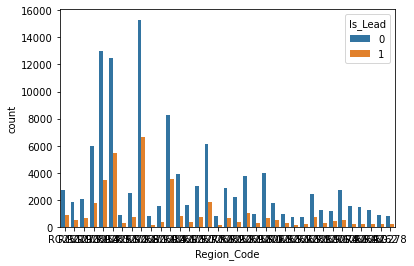

<Figure size 432x216 with 0 Axes>

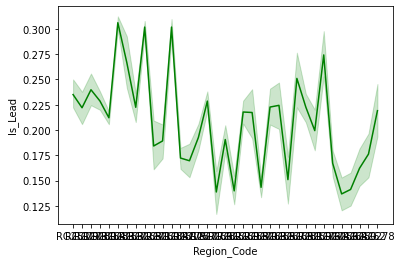

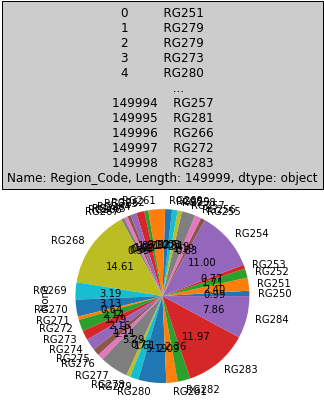



--------- Occupation vs Is_Lead---------------------------------------------------------------------------------


Occupation
Self_Employed    61494
Salaried         44048
Other            42807
Entrepreneur      1650
Name: Occupation, dtype: int64




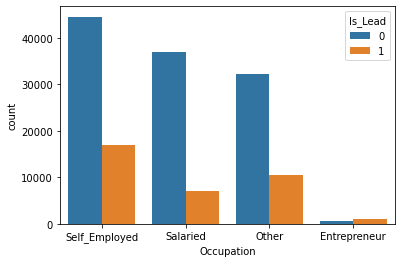

<Figure size 432x216 with 0 Axes>

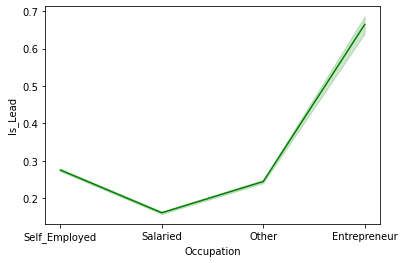

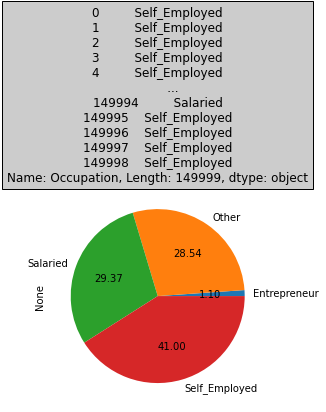



--------- Channel_Code vs Is_Lead---------------------------------------------------------------------------------


Channel_Code
X1    63276
X3    42005
X2    41415
X4     3303
Name: Channel_Code, dtype: int64




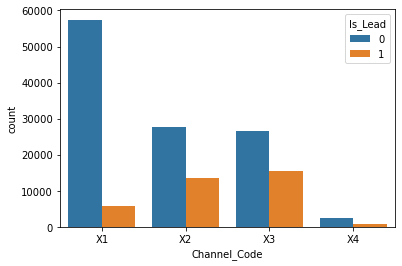

<Figure size 432x216 with 0 Axes>

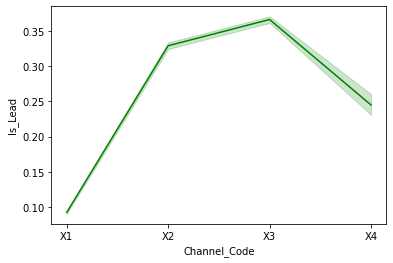

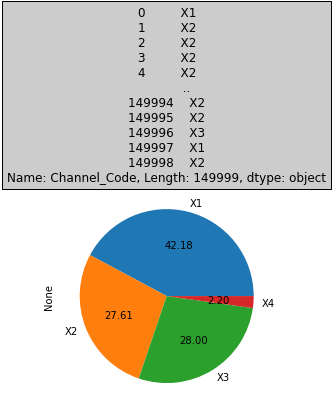



--------- Is_Active vs Is_Lead---------------------------------------------------------------------------------


Is_Active
No     91564
Yes    58435
Name: Is_Active, dtype: int64




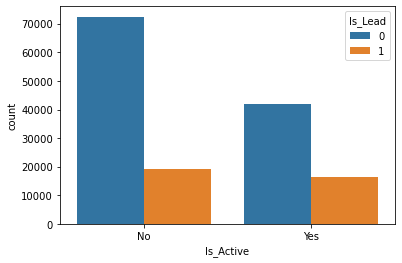

<Figure size 432x216 with 0 Axes>

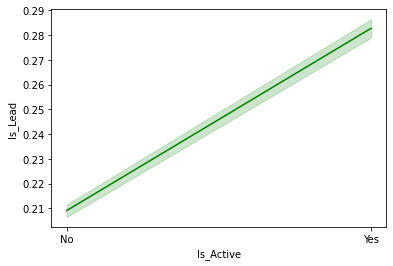

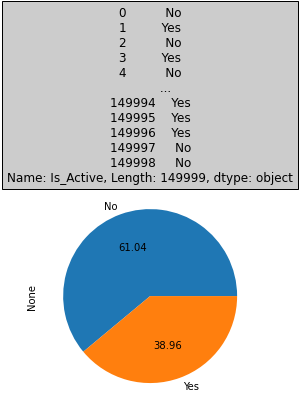

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
gs1 = gridspec.GridSpec(2, 1)



def relationwithlabel(x):
    print(x.value_counts())
    print("\n")
    
    #countplot with hue label
    sns.countplot(x=x, hue='Is_Lead',data = df)
    plt.figure(figsize=(6,3))
    plt.show()
    
    sns.lineplot(x=x,y="Is_Lead",data=df, color='green')
    plt.show()
    
    
    df.groupby(x).size().plot(kind='pie', autopct='%.2f')
    plt.title(str(x),bbox={'facecolor':'0.8', 'pad':5})
    plt.show()
    
    #plt.xticks(rotation = 45, ha = 'right')
    #plt.legend(title = 'Number', bbox_to_anchor = (1, 1))          

categorical_columns=['Gender','Region_Code', 'Occupation', 'Channel_Code', 'Is_Active']

for column_name in categorical_columns:
    print("---------",column_name,"vs Is_Lead---------------------------------------------------------------------------------")
    print("\n")
    print(str(column_name))
    relationwithlabel(df[str(column_name)])
    print("\n")

**2.Relationship between Numerical features and label**

C:\Users\91890\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\91890\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\91890\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

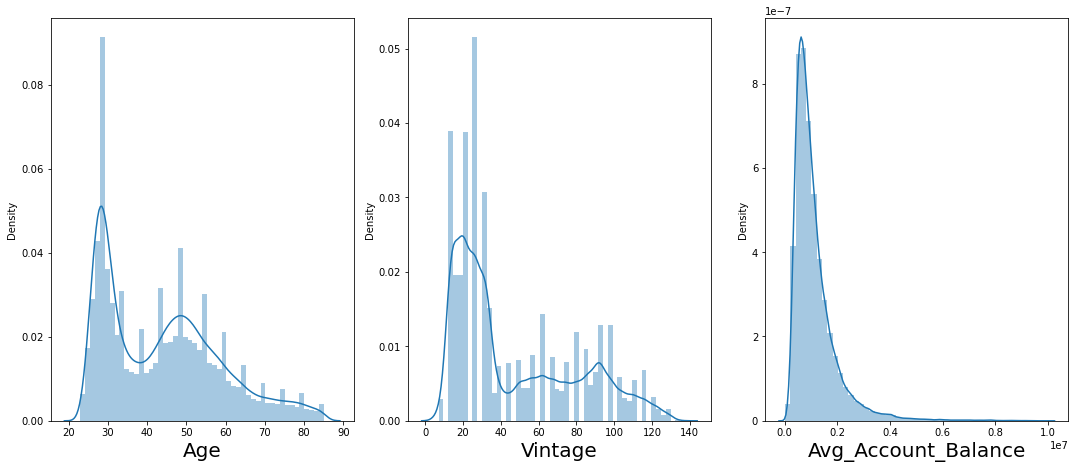

In [27]:
x = df[[ 'Age', 'Vintage','Avg_Account_Balance']].copy()
y=df['Is_Lead']
#understanding relationship between features and label
plt.figure(figsize=(20,25),facecolor='white')
plotnumber=1

for column in x:
    if plotnumber<=16:
       ax=plt.subplot(4,4,plotnumber)
       sns.distplot(x[column])         #distribution plot- we use for continous data
       plt.xlabel(column,fontsize=20)

    plotnumber+=1
plt.tight_layout()
plt.show()

In [28]:
df.describe()

,Age,Vintage,Avg_Account_Balance,Is_Lead
count,149999.000000,149999.000000,1.499990e+05,149999.000000
mean,43.850466,46.960406,1.129887e+06,0.237795
std,14.836576,32.329112,8.549330e+05,0.425734
min,23.000000,7.000000,2.079000e+04,0.000000
25%,30.000000,20.000000,6.052040e+05,0.000000
50%,43.000000,32.000000,8.966660e+05,0.000000
75%,54.000000,74.000000,1.368086e+06,0.000000
max,85.000000,135.000000,1.000768e+07,1.000000


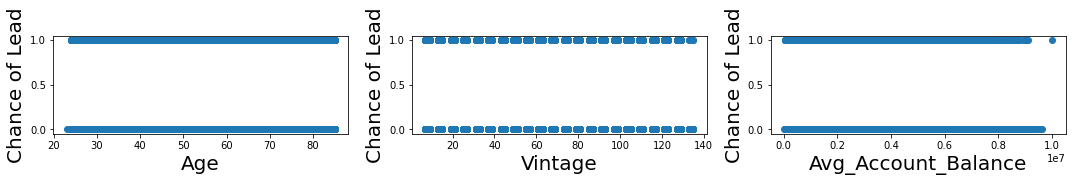

In [29]:
#visualising the relationship
plt.figure(figsize=(15,10),facecolor='white')
plotnumber=1

for column in x:
    if plotnumber<=15:
        X=plt.subplot(5,3,plotnumber)
        plt.scatter(x[column],y)
        plt.xlabel(column,fontsize=20)
        plt.ylabel('Chance of Lead',fontsize=20)
    plotnumber+=1
plt.tight_layout()
plt.show()

# FEATURE ENGINEERING

**1.Dropping the ID Column**

In [30]:
df_pyspark = df_pyspark.drop("ID")
df_pyspark

DataFrame[Gender: string, Age: int, Region_Code: string, Occupation: string, Channel_Code: string, Vintage: int, Credit_Product: string, Avg_Account_Balance: int, Is_Active: string, Is_Lead: int]

**2.seperating categorical and numerical columns**

In [31]:
cat_cols=[x for (x,dataType) in df_pyspark.dtypes if dataType == "string"]

num_cols=[x for (x,dataType) in df_pyspark.dtypes if ((dataType == 'double') & (x!='Is_Lead'))]

**3.Converting Numerical column into Integer type**

In [32]:
from pyspark.sql import functions as f
from pyspark.sql.types import IntegerType

for column in num_cols:
    df_pyspark = df_pyspark.withColumn(column,f.col(column).cast(IntegerType()))

**4.Storing numerical columns into a list**

In [33]:
numeric_columns = [column[0] for column in df_pyspark.dtypes if column[1]=='int']
numeric_columns

['Age', 'Vintage', 'Avg_Account_Balance', 'Is_Lead']

# Exploratory Data Analysis

In [34]:
# importing some libraries for EDA

import numpy as np
from pyspark.sql import functions as F

from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

**1.Dealing with null values**

In [35]:
#print all features and its null values
for col in df_pyspark.columns:
    print(col+":",df_pyspark[df_pyspark[col].isNull()].count())

Gender: 0
Age: 0
Region_Code: 0
Occupation: 0
Channel_Code: 0
Vintage: 0
Credit_Product: 17963
Avg_Account_Balance: 0
Is_Active: 0
Is_Lead: 0


<AxesSubplot:>

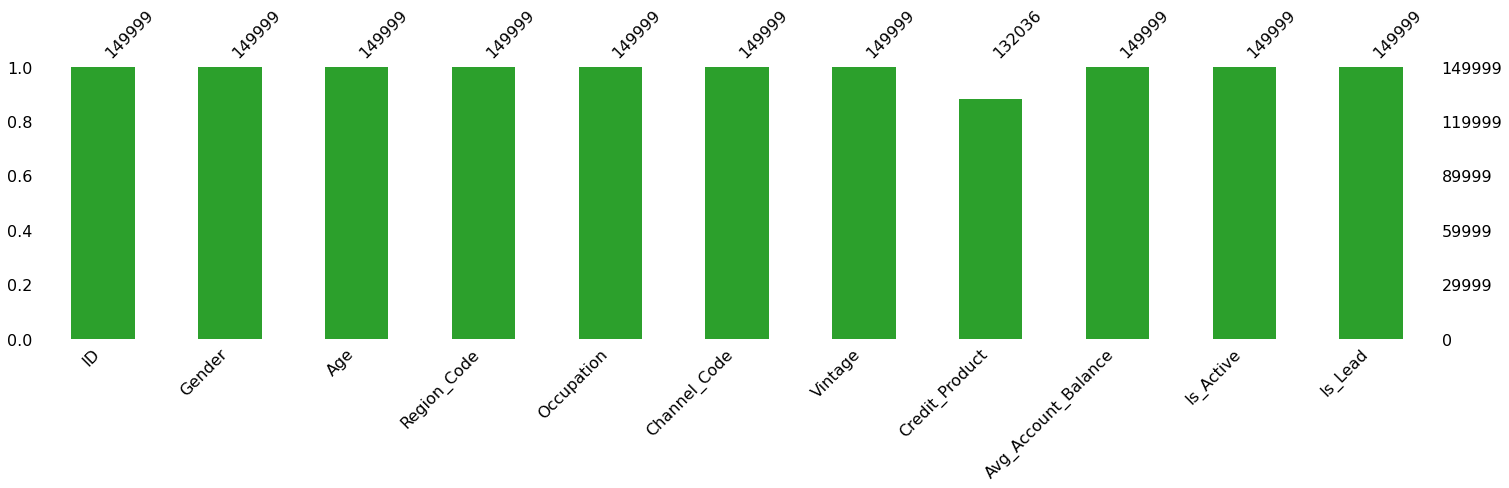

In [36]:
#finding the nan values
import missingno
missingno.bar(df, figsize = (25,5), color="tab:green")

Credit_product shows to have null values

In [37]:
#dropping rows of null values
print("number of rows before dropping null values",df_pyspark.count())
df_pyspark=df_pyspark.na.drop()
df.dropna(inplace=True)
print("number of rows after dropping null values",df_pyspark.count())

number of rows before dropping null values 149999
number of rows after dropping null values 132036


In [38]:
## See if we have missing values
from pyspark.sql.functions import isnull, when, count, col

df_pyspark.select([count(when(isnull(c), c)).alias(c) for c in df_pyspark.columns]).show()

+------+---+-----------+----------+------------+-------+--------------+-------------------+---------+-------+
|Gender|Age|Region_Code|Occupation|Channel_Code|Vintage|Credit_Product|Avg_Account_Balance|Is_Active|Is_Lead|
+------+---+-----------+----------+------------+-------+--------------+-------------------+---------+-------+
|     0|  0|          0|         0|           0|      0|             0|                  0|        0|      0|
+------+---+-----------+----------+------------+-------+--------------+-------------------+---------+-------+



**2.dealing with duplicates**

In [39]:
print("number of rows before dropping duplicate values",df_pyspark.count())
df_pyspark=df_pyspark.dropDuplicates()
df.drop_duplicates(inplace=True)
print("number of rows after dropping duplicate values",df_pyspark.count())

number of rows before dropping duplicate values 132036
number of rows after dropping duplicate values 132030


**3.Dealing with datas with Zero values**

In [40]:
df_pyspark.columns

['Gender',
 'Age',
 'Region_Code',
 'Occupation',
 'Channel_Code',
 'Vintage',
 'Credit_Product',
 'Avg_Account_Balance',
 'Is_Active',
 'Is_Lead']

In [41]:
def count_zeros():
    columns_list=['Gender','Age','Region_Code','Occupation','Channel_Code','Vintage','Credit_Product','Avg_Account_Balance','Is_Active']
    for i in columns_list:
        print(i+":",df_pyspark[df_pyspark[i]==0].count())
        
count_zeros()

Gender: 0
Age: 0
Region_Code: 0
Occupation: 0
Channel_Code: 0
Vintage: 0
Credit_Product: 0
Avg_Account_Balance: 0
Is_Active: 0


None of the columns has zero values

**4.Dealing with datas with Zero values**

In [42]:
def count_space():
    columns_list=['Gender','Age','Region_Code','Occupation','Channel_Code','Vintage','Credit_Product','Avg_Account_Balance','Is_Active']
    for i in columns_list:
        print(i+":",df_pyspark[df_pyspark[i]==""].count())
        
count_space()

Gender: 0
Age: 0
Region_Code: 0
Occupation: 0
Channel_Code: 0
Vintage: 0
Credit_Product: 0
Avg_Account_Balance: 0
Is_Active: 0


None of the columns has empty spaces

**5.Making the Dataset Normal**

1. Dealing with outliers
2. Dealing with skewness

**A.OUTLIERS**

In [43]:
df_pyspark.dtypes

[('Gender', 'string'),
 ('Age', 'int'),
 ('Region_Code', 'string'),
 ('Occupation', 'string'),
 ('Channel_Code', 'string'),
 ('Vintage', 'int'),
 ('Credit_Product', 'string'),
 ('Avg_Account_Balance', 'int'),
 ('Is_Active', 'string'),
 ('Is_Lead', 'int')]

In [44]:
#getting 25th and 75th percentile values for each of column
num_col=df_pyspark.select(['Age','Vintage','Avg_Account_Balance'])

bounds = {
    c: dict(
        zip(["q1", "q3"], num_col.approxQuantile(c, [0.25, 0.75], 0))
    )
    for c in num_col.columns
}

#compute the iqr and upper/lower bounds
for c in bounds:
    iqr = bounds[c]['q3'] - bounds[c]['q1']
    bounds[c]['lower'] = bounds[c]['q1'] - (iqr * 1.5)
    bounds[c]['upper'] = bounds[c]['q3'] + (iqr * 1.5)
    
print(bounds)

{'Age': {'q1': 29.0, 'q3': 53.0, 'lower': -7.0, 'upper': 89.0}, 'Vintage': {'q1': 20.0, 'q3': 67.0, 'lower': -50.5, 'upper': 137.5}, 'Avg_Account_Balance': {'q1': 596896.0, 'q3': 1349711.0, 'lower': -532326.5, 'upper': 2478933.5}}


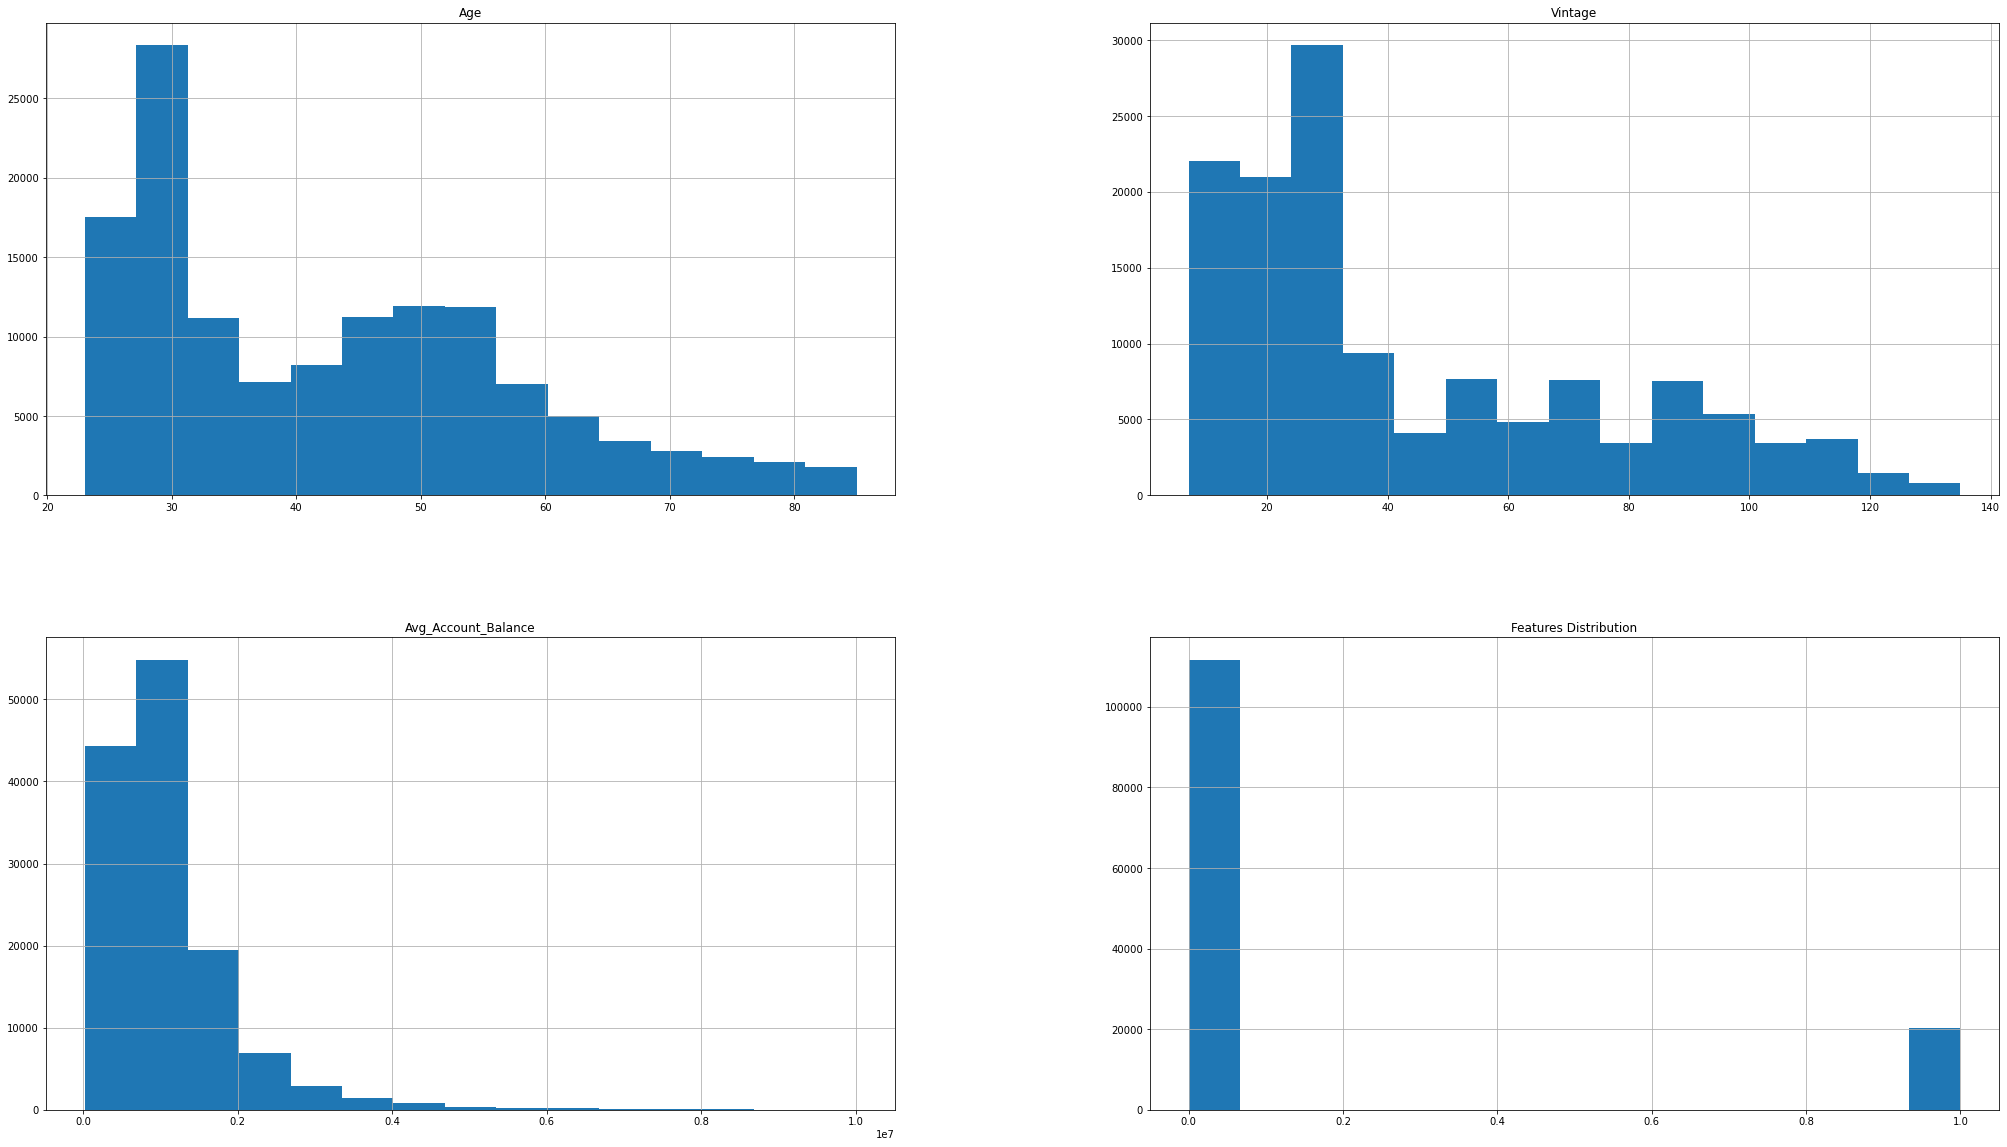

In [45]:
import matplotlib.pyplot as plt
%matplotlib inline

df = df_pyspark.toPandas()

#checking for skewness
df.hist(figsize=(35,20),bins = 15)
plt.title("Features Distribution")
plt.show()

In [46]:
df_pyspark.show(2)

+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+
|Gender|Age|Region_Code|   Occupation|Channel_Code|Vintage|Credit_Product|Avg_Account_Balance|Is_Active|Is_Lead|
+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+
|  Male| 46|      RG268|Self_Employed|          X2|     73|            No|             741859|      Yes|      0|
|Female| 27|      RG256|Self_Employed|          X1|     19|           Yes|             857123|       No|      0|
+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+
only showing top 2 rows



In [47]:
def find_outliers(df):

    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,f.when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]

    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',sum(df[column] for column in selected_columns))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

new_df = find_outliers(df_pyspark)

new_df_with_no_outliers = new_df.filter(new_df['total_Outliers']<=1)
new_df_with_no_outliers = new_df_with_no_outliers.select(*df_pyspark.columns)

print(new_df_with_no_outliers.show())


print("number of rows before dropping ouliers",df_pyspark.count())


print("number of rows after dropping outliers",new_df_with_no_outliers.count())


+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+
|Gender|Age|Region_Code|   Occupation|Channel_Code|Vintage|Credit_Product|Avg_Account_Balance|Is_Active|Is_Lead|
+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+
|  Male| 46|      RG268|Self_Employed|          X2|     73|            No|             741859|      Yes|      0|
|Female| 27|      RG256|Self_Employed|          X1|     19|           Yes|             857123|       No|      0|
|Female| 63|      RG274|        Other|          X2|     99|           Yes|             911226|      Yes|      0|
|  Male| 63|      RG254|        Other|          X3|     55|            No|            2914180|      Yes|      0|
|  Male| 61|      RG283|Self_Employed|          X3|    103|           Yes|            1989942|      Yes|      1|
|  Male| 32|      RG263|     Salaried|          X1|     27|            No|             613859|  

In [48]:
new_df_with_no_outliers=df_pyspark

**SKEWNESS**

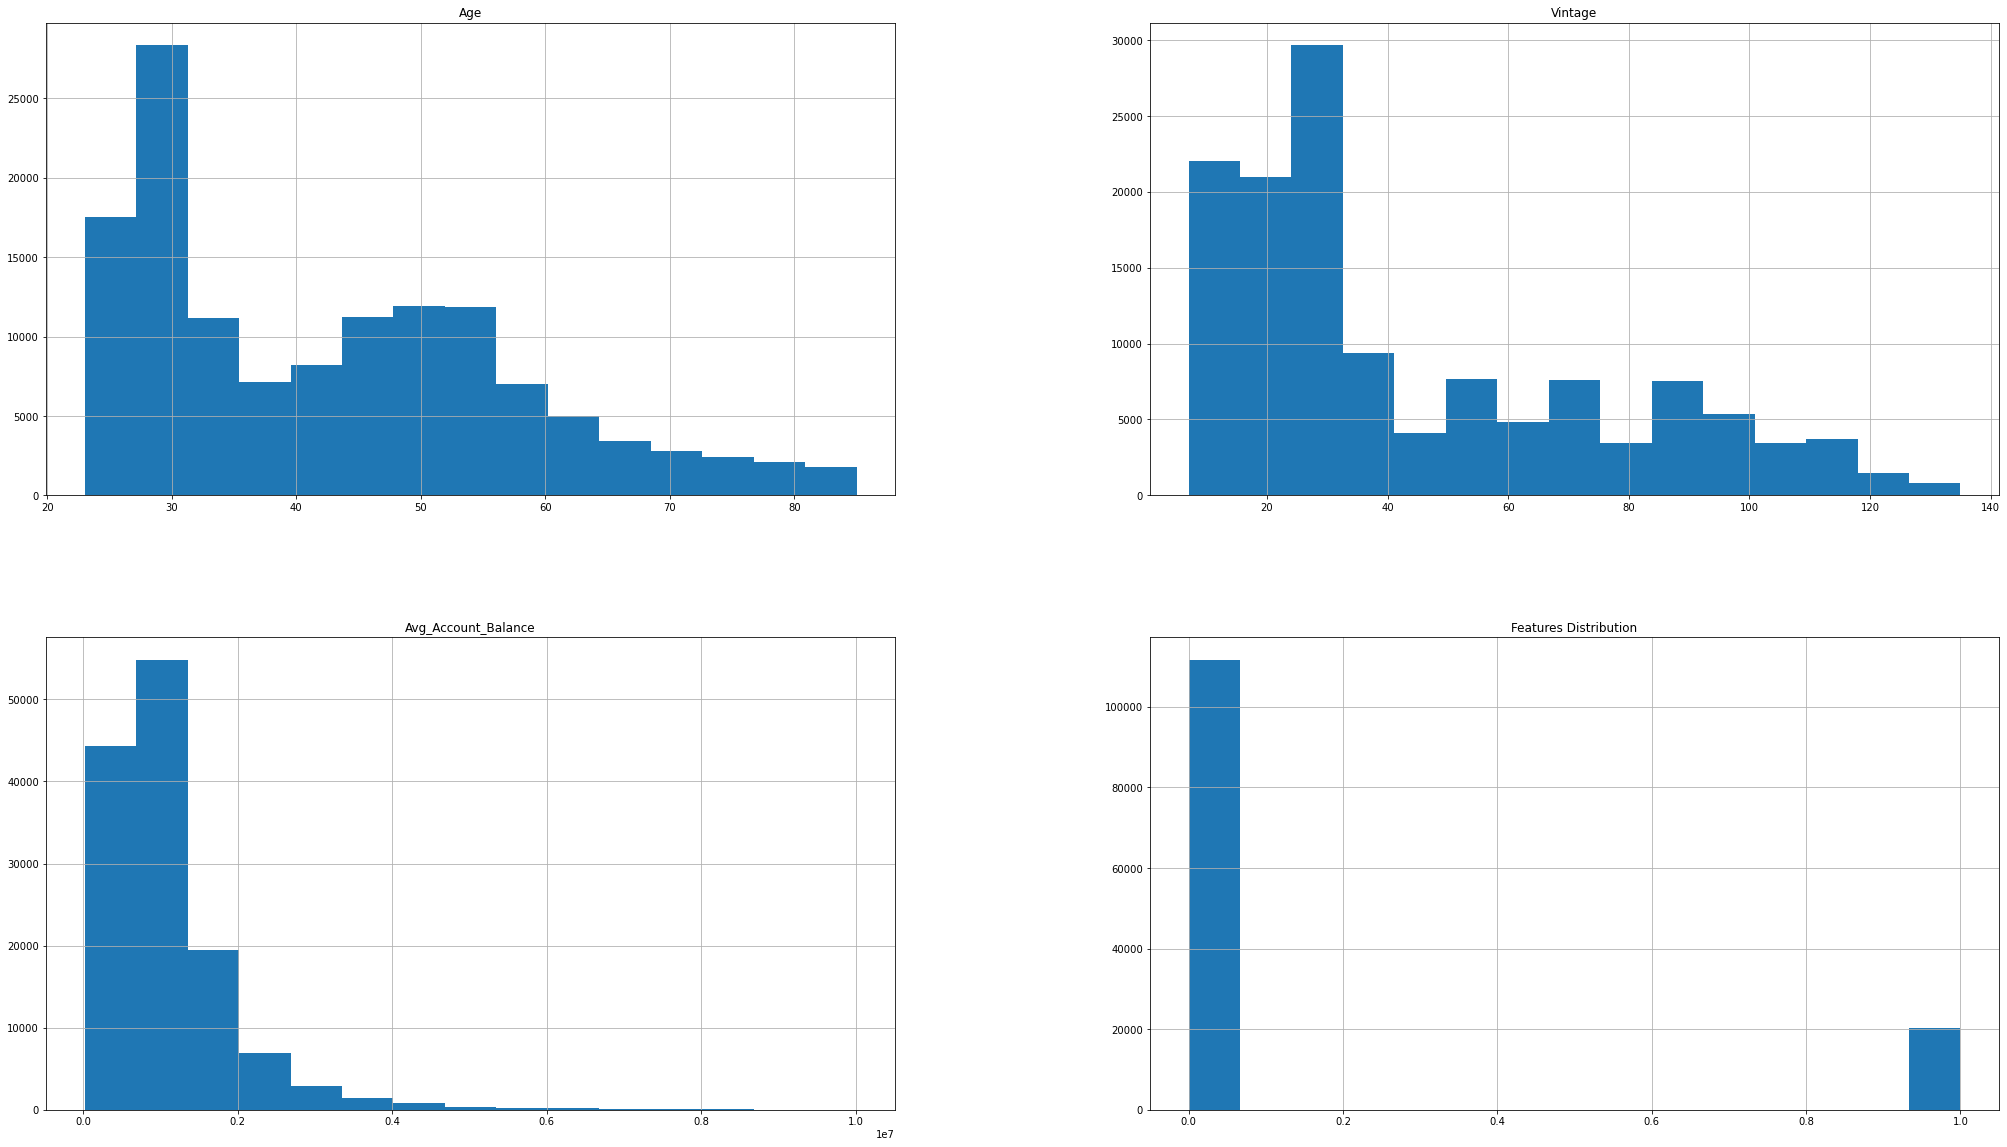

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

df = df_pyspark.toPandas()

#checking for skewness
df.hist(figsize=(35,20),bins = 15)
plt.title("Features Distribution")
plt.show()

skewness is still present, hence standardisation is needed to be done

**Checking if Label is balanced**

In [50]:
df_pyspark.groupby('Is_Lead').count().toPandas()

,Is_Lead,count
0,1,20362
1,0,111668


<AxesSubplot:title={'center':'count (target)'}>

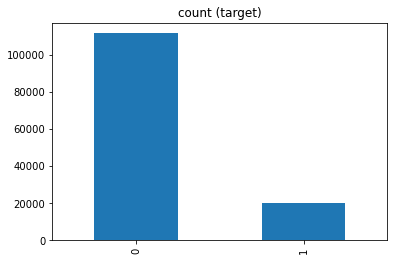

In [51]:
df['Is_Lead'].value_counts().plot(kind='bar', title='count (target)')

In [52]:
#balancing class
df=df_pyspark.toPandas()

# class count
class_count_0, class_count_1 = df['Is_Lead'].value_counts()

#Separate class
class_0 = df[df['Is_Lead'] == 1]
class_1 = df[df['Is_Lead'] == 0]

print('class No/0:', class_0.shape)
print('class Yes/1:', class_1.shape)

class No/0: (20362, 10)
class Yes/1: (111668, 10)


The dataset is imbalanced

# FEATURE ENGINEERING on categorical data

# 1.Dealing with categorical data-One Hot encoding

In [53]:
df_pyspark.dtypes

[('Gender', 'string'),
 ('Age', 'int'),
 ('Region_Code', 'string'),
 ('Occupation', 'string'),
 ('Channel_Code', 'string'),
 ('Vintage', 'int'),
 ('Credit_Product', 'string'),
 ('Avg_Account_Balance', 'int'),
 ('Is_Active', 'string'),
 ('Is_Lead', 'int')]

In [54]:
from pyspark.ml.feature import (OneHotEncoder,StringIndexer)

cat_cols=['Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active']
num_cols=['Age','Vintage','Avg_Account_Balance']

string_indexer = [
    StringIndexer(inputCol=i, outputCol=i + "_StringIndexer", handleInvalid="skip")
    for i in cat_cols
]

one_hot_encoder = [
    OneHotEncoder(
        inputCols=[f"{i}_StringIndexer" for i in cat_cols],
        outputCols=[f"{i}_OneHotEncoder" for i in cat_cols],
    )
]

The last category is not included by default (configurable via OneHotEncoder!.dropLast because it makes the vector entries sum up to one, and hence linearly dependent.

**2.Vector Assembling**

In [55]:
from pyspark.ml.feature import VectorAssembler

assemblerInput = [x for x in num_cols]
assemblerInput += [f"{i}_OneHotEncoder" for i in cat_cols]
vector_assembler = VectorAssembler(inputCols=assemblerInput, outputCol="One_hot_encoded_features")

In [56]:
stages = []
stages += string_indexer
stages += one_hot_encoder
stages += [vector_assembler]
stages

[StringIndexer_aff91d0bbf77,
 StringIndexer_3ad77b4b7f33,
 StringIndexer_c49455b71a71,
 StringIndexer_8b65a177fbe1,
 StringIndexer_c4bb8124090e,
 StringIndexer_2276818e514f,
 OneHotEncoder_f798875ef98d,
 VectorAssembler_38f272735f26]

These are the stages which needs to be brought into a pipeline

In [57]:
%%time
from pyspark.ml import Pipeline

pipeline = Pipeline().setStages(stages)
model = pipeline.fit(df_pyspark)

pp_df = model.transform(df_pyspark)

Wall time: 7.43 s


In [58]:
pp_df.show(2)

+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+------------------------+
|Gender|Age|Region_Code|   Occupation|Channel_Code|Vintage|Credit_Product|Avg_Account_Balance|Is_Active|Is_Lead|Gender_StringIndexer|Region_Code_StringIndexer|Occupation_StringIndexer|Channel_Code_StringIndexer|Credit_Product_StringIndexer|Is_Active_StringIndexer|Gender_OneHotEncoder|Region_Code_OneHotEncoder|Occupation_OneHotEncoder|Channel_Code_OneHotEncoder|Credit_Product_OneHotEncoder|Is_Active_OneHotEncoder|One_hot_encoded_features|
+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+-------+----

In [59]:
df_pyspark=pp_df

In [60]:
cat_cols

['Gender',
 'Region_Code',
 'Occupation',
 'Channel_Code',
 'Credit_Product',
 'Is_Active']

In [61]:
df_pyspark_withcat=df_pyspark

In [62]:
#dropping encoded columns
df_pyspark_withoutcat = df_pyspark_withcat.drop('Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active')

In [63]:
df_pyspark_withcat.columns

['Gender',
 'Age',
 'Region_Code',
 'Occupation',
 'Channel_Code',
 'Vintage',
 'Credit_Product',
 'Avg_Account_Balance',
 'Is_Active',
 'Is_Lead',
 'Gender_StringIndexer',
 'Region_Code_StringIndexer',
 'Occupation_StringIndexer',
 'Channel_Code_StringIndexer',
 'Credit_Product_StringIndexer',
 'Is_Active_StringIndexer',
 'Gender_OneHotEncoder',
 'Region_Code_OneHotEncoder',
 'Occupation_OneHotEncoder',
 'Channel_Code_OneHotEncoder',
 'Credit_Product_OneHotEncoder',
 'Is_Active_OneHotEncoder',
 'One_hot_encoded_features']

In [64]:
assembler1 = VectorAssembler(inputCols=df_pyspark_withoutcat.columns[1:],outputCol="features")
outdata1 = assembler1.transform(df_pyspark_withoutcat)
df_pyspark_withoutcat=outdata1

**features** is the Vector Assembly of Categorical and numerical features

In [65]:
df_pyspark_withoutcat.show(2)

+---+-------+-------------------+-------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+------------------------+--------------------+
|Age|Vintage|Avg_Account_Balance|Is_Lead|Gender_StringIndexer|Region_Code_StringIndexer|Occupation_StringIndexer|Channel_Code_StringIndexer|Credit_Product_StringIndexer|Is_Active_StringIndexer|Gender_OneHotEncoder|Region_Code_OneHotEncoder|Occupation_OneHotEncoder|Channel_Code_OneHotEncoder|Credit_Product_OneHotEncoder|Is_Active_OneHotEncoder|One_hot_encoded_features|            features|
+---+-------+-------------------+-------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+--------------------+--

# 2. BALANCING THE LABEL USING SMOTE

**Oversampling** :The idea of oversampling, is to duplicate the samples from under-represented class, to inflate the numbers till it reaches the same level as the dominant class.

In [66]:
from pyspark.sql.functions import col, explode, array, lit
major_df = df_pyspark_withoutcat.filter(col("Is_Lead") == 0)
minor_df = df_pyspark_withoutcat.filter(col("Is_Lead") == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

ratio: 5


In [67]:
a = range(ratio)

# duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')

# combine both oversampled minority rows and previous majority rows
combined_df = major_df.unionAll(oversampled_df)
combined_df.show(2)

+---+-------+-------------------+-------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+------------------------+--------------------+
|Age|Vintage|Avg_Account_Balance|Is_Lead|Gender_StringIndexer|Region_Code_StringIndexer|Occupation_StringIndexer|Channel_Code_StringIndexer|Credit_Product_StringIndexer|Is_Active_StringIndexer|Gender_OneHotEncoder|Region_Code_OneHotEncoder|Occupation_OneHotEncoder|Channel_Code_OneHotEncoder|Credit_Product_OneHotEncoder|Is_Active_OneHotEncoder|One_hot_encoded_features|            features|
+---+-------+-------------------+-------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+--------------------+--

we create a new dummy column containing a literal array of numbers, with the array size being the multiplier we want to apply to minority class rows. Then theexplode function create a new row for each element in the array. Last we drop the dummy column.

<AxesSubplot:title={'center':'count (target)'}>

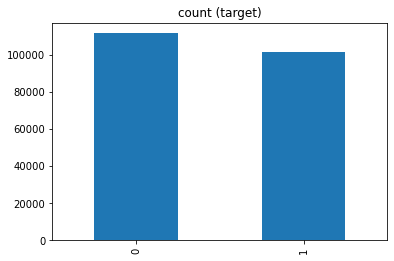

In [68]:
df=combined_df.toPandas()
df['Is_Lead'].value_counts().plot(kind='bar', title='count (target)')

The classes are balanced 

In [69]:
df_pyspark=combined_df

In [70]:
df_pyspark.show(2)

+---+-------+-------------------+-------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+------------------------+--------------------+
|Age|Vintage|Avg_Account_Balance|Is_Lead|Gender_StringIndexer|Region_Code_StringIndexer|Occupation_StringIndexer|Channel_Code_StringIndexer|Credit_Product_StringIndexer|Is_Active_StringIndexer|Gender_OneHotEncoder|Region_Code_OneHotEncoder|Occupation_OneHotEncoder|Channel_Code_OneHotEncoder|Credit_Product_OneHotEncoder|Is_Active_OneHotEncoder|One_hot_encoded_features|            features|
+---+-------+-------------------+-------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+--------------------+--

Features present until now:

1. Numerical features

2. Categorical features

3. Vector assembly of encoded categorical variables and numerical variables-Features

# FEATURE SELECTION

In [71]:
df_pyspark.dtypes

[('Age', 'int'),
 ('Vintage', 'int'),
 ('Avg_Account_Balance', 'int'),
 ('Is_Lead', 'int'),
 ('Gender_StringIndexer', 'double'),
 ('Region_Code_StringIndexer', 'double'),
 ('Occupation_StringIndexer', 'double'),
 ('Channel_Code_StringIndexer', 'double'),
 ('Credit_Product_StringIndexer', 'double'),
 ('Is_Active_StringIndexer', 'double'),
 ('Gender_OneHotEncoder', 'vector'),
 ('Region_Code_OneHotEncoder', 'vector'),
 ('Occupation_OneHotEncoder', 'vector'),
 ('Channel_Code_OneHotEncoder', 'vector'),
 ('Credit_Product_OneHotEncoder', 'vector'),
 ('Is_Active_OneHotEncoder', 'vector'),
 ('One_hot_encoded_features', 'vector'),
 ('features', 'vector')]

**1.NUMERICAL FEATURES**

A.CORRELATION COEFFICIENT

In [72]:
#find the correlation between the set of input & output variables
num=df_pyspark.select('Age','Vintage','Avg_Account_Balance')

for i in num.columns:
  print(f'Correlation to outcome for {i} is {df_pyspark.stat.corr("Is_Lead",i)}')

Correlation to outcome for Age is 0.24556330288735184
Correlation to outcome for Vintage is 0.28789325876646077
Correlation to outcome for Avg_Account_Balance is 0.058314250961423855


Least correlation is seen with Avg_Account_Balance,hence it can be dropped to improve Accuracy or F1 score

B.CORRELATION MATRIX

In [73]:
import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

columns = ['Age','Vintage','Avg_Account_Balance']
df=df_pyspark
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=['Age','Vintage','Avg_Account_Balance'], 
                            outputCol=vector_col)
df_pyspark_vector = assembler.transform(df_pyspark).select(vector_col)

matrix = Correlation.corr(df_pyspark_vector, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()

df_ = spark.createDataFrame(corrmatrix,columns)
df_.show()

C:\spark-3.2.1-bin-hadoop3.2\python\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+-------------------+-------------------+-------------------+
|                Age|            Vintage|Avg_Account_Balance|
+-------------------+-------------------+-------------------+
|                1.0| 0.6219984354987125|0.14752404667393018|
| 0.6219984354987125|                1.0|0.17989380114828804|
|0.14752404667393018|0.17989380114828804|                1.0|
+-------------------+-------------------+-------------------+



C.HEATMAP

<ipython-input-74-19bc91d92c17>:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+attr)
<ipython-input-74-19bc91d92c17>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+attr)


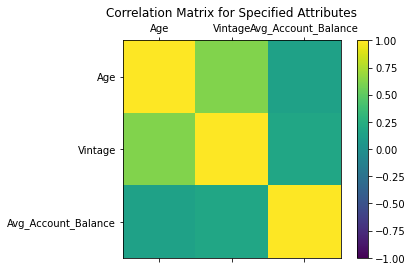

In [74]:
def plot_corr_matrix(correlations,attr,fig_no):
    fig=plt.figure(fig_no)
    ax=fig.add_subplot(111)
    ax.set_title("Correlation Matrix for Specified Attributes")
    ax.set_xticklabels(['']+attr)
    ax.set_yticklabels(['']+attr)
    cax=ax.matshow(correlations,vmax=1,vmin=-1)
    fig.colorbar(cax)
    plt.show()

plot_corr_matrix(corrmatrix, columns, 234)

Multicollinearity is not seen in the dataset

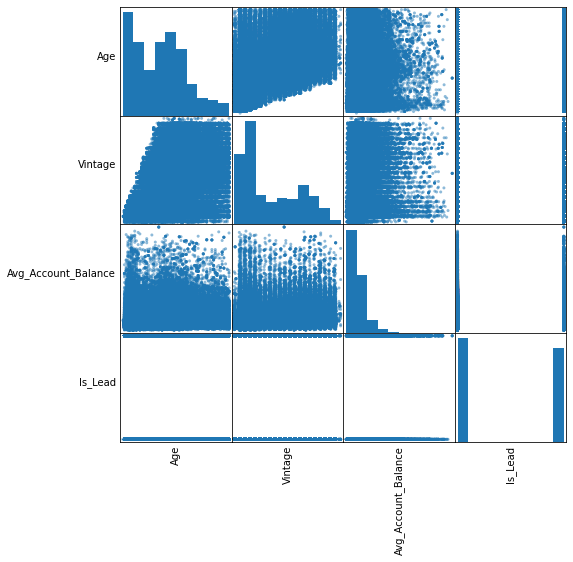

In [75]:
numeric_features = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(numeric_features).describe().toPandas().transpose()

from pandas.plotting import scatter_matrix
numeric_data = df.select(numeric_features).toPandas()

axs = scatter_matrix(numeric_data, figsize=(8, 8));

# Rotate axis labels and remove axis ticks
n = len(numeric_data.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

**2.CATEGORICAL FEATURES**

**A.CHI SQUARED TEST**

To find correlation with Target variable

In [76]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import ChiSquareTest

df_1=df_pyspark_withcat
 
Gender_indexer = StringIndexer(inputCol = "Gender", outputCol = "Gender_index")
Region_Code_indexer = StringIndexer(inputCol = "Region_Code", outputCol = "Region_Code_index")
Occupation_indexer = StringIndexer(inputCol = "Occupation", outputCol = "Occupation_index")
Channel_Code_indexer = StringIndexer(inputCol = "Channel_Code", outputCol = "Channel_Code_index")
Credit_Product_indexer = StringIndexer(inputCol = "Credit_Product", outputCol = "Credit_Product_index")
Is_Active_indexer = StringIndexer(inputCol = "Is_Active", outputCol = "Is_Active_index")
Is_Lead_indexer = StringIndexer(inputCol = "Is_Lead", outputCol = "Is_Lead_index")

assembler = VectorAssembler(inputCols = ["Gender_index", "Region_Code_index","Occupation_index","Channel_Code_index","Credit_Product_index","Is_Active_index"], outputCol = "features")
 
pipeline = Pipeline(stages = [Gender_indexer, Region_Code_indexer, Occupation_indexer, Channel_Code_indexer,Credit_Product_indexer,Is_Active_indexer,Is_Lead_indexer,assembler])
model = pipeline.fit(df_1).transform(df_1)

In [77]:
chi_test = ChiSquareTest.test(model, "features", "Is_Lead_index")
chi_test.show(truncate=False)

+-------------------------+-------------------+-----------------------------------------------------------------------------------------------------------------+
|pValues                  |degreesOfFreedom   |statistics                                                                                                       |
+-------------------------+-------------------+-----------------------------------------------------------------------------------------------------------------+
|[0.0,0.0,0.0,0.0,0.0,0.0]|[1, 34, 3, 3, 1, 1]|[427.01098887830295,1296.6854487826756,1915.0496400855577,6568.828730178657,13088.510821706437,621.0209013391752]|
+-------------------------+-------------------+-----------------------------------------------------------------------------------------------------------------+



Chi square statistic test results:
1. Gender-427.01098887830295
2. Region_Code-1296.6854487826756
3. Occupation-1915.0496400855577
4. Channel_Code-6568.828730178657
5. Credit_Product-13088.510821706437
6. Is_Active-621.0209013391752

The test statistic tells how much difference would exist between observed counts and the counts one would expect if there was no relationship.

Here the maximum relationship can be seen for Credit_Product Feature.

**Relationship significance order:** Credit_Product>Channel Code>Occupation>Region_Code>Is_Active>Gender


The least significant feature is Gender

**B.SPEARMAN RANK CORRELATION**

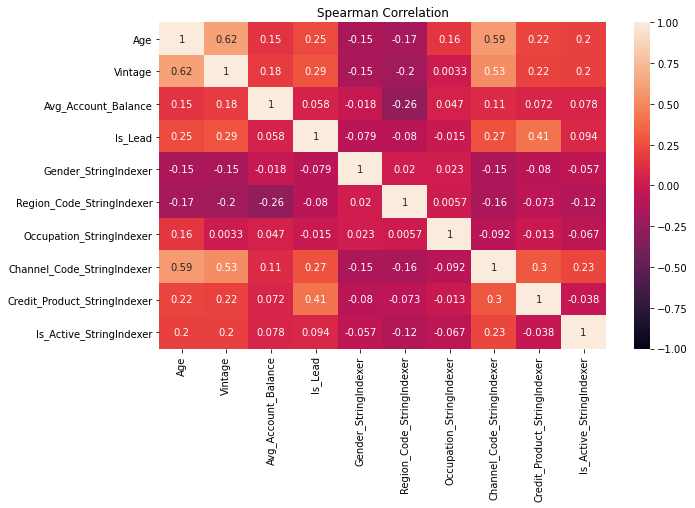

In [78]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt

df=df_pyspark.toPandas()

my_r = df.corr(method="spearman")

def display_correlation(df):
    r = df.corr(method="spearman")
    plt.figure(figsize=(10,6))
    heatmap = sns.heatmap(df.corr(), vmin=-1, 
                      vmax=1, annot=True)
    plt.title("Spearman Correlation")
    return(r)

r_simple=display_correlation(df)

multicollinearity much is not seen among the categorical features

In [79]:
df_pyspark_withoutcat.show(2)

+---+-------+-------------------+-------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+------------------------+--------------------+
|Age|Vintage|Avg_Account_Balance|Is_Lead|Gender_StringIndexer|Region_Code_StringIndexer|Occupation_StringIndexer|Channel_Code_StringIndexer|Credit_Product_StringIndexer|Is_Active_StringIndexer|Gender_OneHotEncoder|Region_Code_OneHotEncoder|Occupation_OneHotEncoder|Channel_Code_OneHotEncoder|Credit_Product_OneHotEncoder|Is_Active_OneHotEncoder|One_hot_encoded_features|            features|
+---+-------+-------------------+-------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+--------------------+--

In [80]:
df_pyspark.show(2)

+---+-------+-------------------+-------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+------------------------+--------------------+
|Age|Vintage|Avg_Account_Balance|Is_Lead|Gender_StringIndexer|Region_Code_StringIndexer|Occupation_StringIndexer|Channel_Code_StringIndexer|Credit_Product_StringIndexer|Is_Active_StringIndexer|Gender_OneHotEncoder|Region_Code_OneHotEncoder|Occupation_OneHotEncoder|Channel_Code_OneHotEncoder|Credit_Product_OneHotEncoder|Is_Active_OneHotEncoder|One_hot_encoded_features|            features|
+---+-------+-------------------+-------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+--------------------+--

In [81]:
df_pyspark_withoutcat.show(2)

+---+-------+-------------------+-------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+------------------------+--------------------+
|Age|Vintage|Avg_Account_Balance|Is_Lead|Gender_StringIndexer|Region_Code_StringIndexer|Occupation_StringIndexer|Channel_Code_StringIndexer|Credit_Product_StringIndexer|Is_Active_StringIndexer|Gender_OneHotEncoder|Region_Code_OneHotEncoder|Occupation_OneHotEncoder|Channel_Code_OneHotEncoder|Credit_Product_OneHotEncoder|Is_Active_OneHotEncoder|One_hot_encoded_features|            features|
+---+-------+-------------------+-------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+--------------------+--

# FEATURE ENGINEERING ON - NUMERICAL VALUES

In [82]:
df_pyspark=df_pyspark_withoutcat.drop('Avg_Account_Balance')

**1.dealing with outliers by bringing down the numerical columns to have 1 standard deviation-done by using STANDARDISATION**

In [83]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
num_cols=['Age','Vintage']

#assembling the numerical features together to perform standardisation
vector_assembler = VectorAssembler(inputCols=num_cols, outputCol="num_features_vector",)
temp_df = vector_assembler.transform(df_pyspark)
temp_df.show(2, truncate=False)

+---+-------+-------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------+-------------------+
|Age|Vintage|Is_Lead|Gender_StringIndexer|Region_Code_StringIndexer|Occupation_StringIndexer|Channel_Code_StringIndexer|Credit_Product_StringIndexer|Is_Active_StringIndexer|Gender_OneHotEncoder|Region_Code_OneHotEncoder|Occupation_OneHotEncoder|Channel_Code_OneHotEncoder|Credit_Product_OneHotEncoder|Is_Active_OneHotEncoder|One_hot_encoded_features                                          |features                                                   

In [84]:
#perform standardisation
standard_scaler = StandardScaler(inputCol="num_features_vector", outputCol="scaled",withStd=True, withMean=False)
df_pyspark= standard_scaler.fit(temp_df).transform(temp_df)
df_pyspark.select("scaled").show(5, truncate=False)

+--------------------------------------+
|scaled                                |
+--------------------------------------+
|[3.0942836203133055,2.338231875615673]|
|[1.816209951053462,0.6085808991328464]|
|[4.237823219124745,3.1710267902185154]|
|[4.237823219124745,1.7616815501213974]|
|[4.10328914867634,3.299149084772799]  |
+--------------------------------------+
only showing top 5 rows



In [85]:
df_pyspark.show(2)

+---+-------+-------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+------------------------+--------------------+-------------------+--------------------+
|Age|Vintage|Is_Lead|Gender_StringIndexer|Region_Code_StringIndexer|Occupation_StringIndexer|Channel_Code_StringIndexer|Credit_Product_StringIndexer|Is_Active_StringIndexer|Gender_OneHotEncoder|Region_Code_OneHotEncoder|Occupation_OneHotEncoder|Channel_Code_OneHotEncoder|Credit_Product_OneHotEncoder|Is_Active_OneHotEncoder|One_hot_encoded_features|            features|num_features_vector|              scaled|
+---+-------+-------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+-

In [86]:
df_pyspark.dtypes

[('Age', 'int'),
 ('Vintage', 'int'),
 ('Is_Lead', 'int'),
 ('Gender_StringIndexer', 'double'),
 ('Region_Code_StringIndexer', 'double'),
 ('Occupation_StringIndexer', 'double'),
 ('Channel_Code_StringIndexer', 'double'),
 ('Credit_Product_StringIndexer', 'double'),
 ('Is_Active_StringIndexer', 'double'),
 ('Gender_OneHotEncoder', 'vector'),
 ('Region_Code_OneHotEncoder', 'vector'),
 ('Occupation_OneHotEncoder', 'vector'),
 ('Channel_Code_OneHotEncoder', 'vector'),
 ('Credit_Product_OneHotEncoder', 'vector'),
 ('Is_Active_OneHotEncoder', 'vector'),
 ('One_hot_encoded_features', 'vector'),
 ('features', 'vector'),
 ('num_features_vector', 'vector'),
 ('scaled', 'vector')]

numerical features have been standardised and normalised into the vector scaled

In [87]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['scaled','num_features_vector'], outputCol="final_features")
data = assembler.transform(df_pyspark)
data.show(2)

+---+-------+-------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+--------------------+-------------------------+------------------------+--------------------------+----------------------------+-----------------------+------------------------+--------------------+-------------------+--------------------+--------------------+
|Age|Vintage|Is_Lead|Gender_StringIndexer|Region_Code_StringIndexer|Occupation_StringIndexer|Channel_Code_StringIndexer|Credit_Product_StringIndexer|Is_Active_StringIndexer|Gender_OneHotEncoder|Region_Code_OneHotEncoder|Occupation_OneHotEncoder|Channel_Code_OneHotEncoder|Credit_Product_OneHotEncoder|Is_Active_OneHotEncoder|One_hot_encoded_features|            features|num_features_vector|              scaled|      final_features|
+---+-------+-------+--------------------+-------------------------+------------------------+--------------------------+------------

In [88]:
df_pyspark=data.select('final_features','Is_Lead')

In [89]:
df_pyspark.show(2)

+--------------------+-------+
|      final_features|Is_Lead|
+--------------------+-------+
|[3.09428362031330...|      0|
|[1.81620995105346...|      0|
+--------------------+-------+
only showing top 2 rows



In [90]:
df_pyspark=df_pyspark.withColumnRenamed("final_features","features")

In [91]:
df_pyspark=df_pyspark.withColumnRenamed("Is_Lead","label")

In [92]:
df_pyspark.show(2)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[3.09428362031330...|    0|
|[1.81620995105346...|    0|
+--------------------+-----+
only showing top 2 rows



# SPLITTING OF DATASET into Train, test and Validation

1. Finding best random state

In [ ]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.classification import LogisticRegression

maxAccu=0
maxRS=0

for i in range(1,200):
    train,test= df_pyspark.randomSplit([0.75,0.25])
    lr = LogisticRegression(labelCol='label', featuresCol='features')
    model= lr.fit(train)
    transformed = model.transform(test)
    evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    acc = evaluatorMulti.evaluate(transformed, {evaluatorMulti.metricName: "accuracy"})
    if acc>maxAccu:
        maxAccu=acc
        maxRS=i

print("Best accuracy is", maxAccu,"on Random State",maxRS)

# Train Test Split

In [93]:
train, test,valid = df_pyspark.randomSplit([0.7, 0.2,0.1], seed = 60)

print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))
print("Validation Dataset Count: " + str(valid.count()))

Training Dataset Count: 92129
Test Dataset Count: 26377
Validation Dataset Count: 13524


In [94]:
train.show(2)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.61440884538085...|    0|
|[1.61440884538085...|    0|
+--------------------+-----+
only showing top 2 rows



# MODEL BUILDING

In [95]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [355]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LinearSVC

RF= RandomForestClassifier(labelCol='label', featuresCol='features', maxDepth=5)
DT = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 3)
GBC = GBTClassifier(labelCol = 'label', featuresCol = 'features')
LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
NB = NaiveBayes(smoothing=1.0, modelType="multinomial",featuresCol = 'features', labelCol = 'label')
SVM= LinearSVC(maxIter=10, regParam=0.1,featuresCol = 'features', labelCol = 'label')


models= []
models.append(('DecisionTreeClassifier', DT))
models.append(('RandomForestClassifier', RF))
models.append(('GradientBoostingClassifier', GBC))
models.append(('LogisticRegression', LR))
models.append(('NaiveBayes', NB))
models.append(('LinearSVC', SVM))

Model= []
accuracy_score=[]
f1_scores=[]
precision_score=[]
recall=[]
roc_score=[]
for name,model in models:
    print('******************************************',name,'********************************************************')
    Model.append(name)
    
    model_= model.fit(train)
    transformed = model_.transform(test)
    print('\n')
    
    evaluatorMulti = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")
    evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction", metricName='areaUnderROC')

    # Get metrics
    acc = evaluatorMulti.evaluate(transformed, {evaluatorMulti.metricName: "accuracy"})
    f1 = evaluatorMulti.evaluate(transformed, {evaluatorMulti.metricName: "f1"})
    weightedPrecision = evaluatorMulti.evaluate(transformed, {evaluatorMulti.metricName: "weightedPrecision"})
    weightedRecall = evaluatorMulti.evaluate(transformed, {evaluatorMulti.metricName: "weightedRecall"})
    auc = evaluator.evaluate(transformed)

    print("Accuracy is \n",acc,"for",name)
    print("F1 score is \n",f1,"for",name)
    print("Precision is \n",weightedPrecision,"for",name)
    print("Recall is \n",weightedRecall,"for",name)
    print("Area under the curve is \n",auc,"for",name)
    

    accuracy_score.append(acc)
    f1_scores.append(f1)
    precision_score.append(weightedPrecision)
    recall.append(weightedRecall)
    roc_score.append(auc)
    
 

****************************************** DecisionTreeClassifier ********************************************************


Accuracy is 
 0.8422110171740531 for DecisionTreeClassifier
F1 score is 
 0.77007399351834 for DecisionTreeClassifier
Precision is 
 0.7093193974493532 for DecisionTreeClassifier
Recall is 
 0.8422110171740531 for DecisionTreeClassifier
Area under the curve is 
 0.5 for DecisionTreeClassifier
****************************************** RandomForestClassifier ********************************************************


Accuracy is 
 0.8420972817227129 for RandomForestClassifier
F1 score is 
 0.7700175395035941 for RandomForestClassifier
Precision is 
 0.7093042812417559 for RandomForestClassifier
Recall is 
 0.8420972817227129 for RandomForestClassifier
Area under the curve is 
 0.499932478055368 for RandomForestClassifier
****************************************** GradientBoostingClassifier ********************************************************


Accuracy is 
 0.8

In [356]:
result = pd.DataFrame({'Model': Model, 'Accuracy_score': acc,'f1 score':f1_scores,'Average precision score':precision_score,'Recall':recall,'roc_score':roc_score})
result

,Model,Accuracy_score,f1 score,Average precision score,Recall,roc_score
0,DecisionTreeClassifier,0.842211,0.770074,0.709319,0.842211,0.500000
1,RandomForestClassifier,0.842211,0.770018,0.709304,0.842097,0.499932
2,GradientBoostingClassifier,0.842211,0.769977,0.723640,0.841870,0.499895
3,LogisticRegression,0.842211,0.770074,0.709319,0.842211,0.500000
4,NaiveBayes,0.842211,0.774530,0.789724,0.762445,0.614218
5,LinearSVC,0.842211,0.770074,0.709319,0.842211,0.500000


# ROC AUC Curve

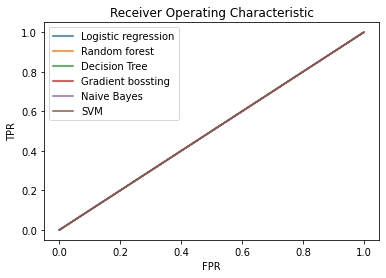

In [357]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc


#predicting the data using the model
model_LR= LR.fit(train)
transformed = model_LR.transform(test)

model_RF= RF.fit(train)
transformed = model_RF.transform(test)

model_DT= DT.fit(train)
transformed = model_DT.transform(test)

model_GBC= GBC.fit(train)
transformed = model_GBC.transform(test)

model_NB= NB.fit(train)
transformed = model_NB.transform(test)

model_SVM= SVM.fit(train)
transformed = model_SVM.transform(test)

#converting the spark dataframe into panda dataframe
transformed_df_LR=transformed.toPandas()
transformed_df_RF=transformed.toPandas()
transformed_df_DT=transformed.toPandas()
transformed_df_GBC=transformed.toPandas()
transformed_df_NB=transformed.toPandas()
transformed_df_SVM=transformed.toPandas()

#making the label and prediction is in integer type and storing them in Y and pred
Y=transformed_df_LR['label'].astype(int)
transformed_df_LR['prediction']=transformed_df_LR['prediction'].astype(int)
pred=transformed_df_LR['prediction']
fpr1 , tpr1, thresholds1 = roc_curve(Y,pred)

Y=transformed_df_RF['label'].astype(int)
transformed_df_RF['prediction']=transformed_df_RF['prediction'].astype(int)
pred=transformed_df_RF['prediction']
fpr2 , tpr2, thresholds2 = roc_curve(Y,pred)

Y=transformed_df_DT['label'].astype(int)
transformed_df_DT['prediction']=transformed_df_DT['prediction'].astype(int)
pred=transformed_df_DT['prediction']
fpr3 , tpr3, thresholds3 = roc_curve(Y,pred)

Y=transformed_df_GBC['label'].astype(int)
transformed_df_GBC['prediction']=transformed_df_GBC['prediction'].astype(int)
pred=transformed_df_GBC['prediction']
fpr4 , tpr4, thresholds4 = roc_curve(Y,pred)

Y=transformed_df_NB['label'].astype(int)
transformed_df_NB['prediction']=transformed_df_NB['prediction'].astype(int)
pred=transformed_df_NB['prediction']
fpr5 , tpr5, thresholds5 = roc_curve(Y,pred)

Y=transformed_df_SVM['label'].astype(int)
transformed_df_SVM['prediction']=transformed_df_SVM['prediction'].astype(int)
pred=transformed_df_SVM['prediction']
fpr6 , tpr6, thresholds6 = roc_curve(Y,pred)


plt.plot([0,1],[0,1], 'k--')
plt.plot(fpr1, tpr1, label= "Logistic regression")
plt.plot(fpr2, tpr2, label= "Random forest")
plt.plot(fpr3, tpr3, label= "Decision Tree")
plt.plot(fpr4, tpr4, label= "Gradient bossting")
plt.plot(fpr5, tpr5, label= "Naive Bayes")
plt.plot(fpr6, tpr6, label= "SVM")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title('Receiver Operating Characteristic')
plt.show()

When 0.5<AUC<1, there is a high chance that the classifier will be able to distinguish the positive class values from the negative class values. This is so because the classifier is able to detect more numbers of True positives and True negatives than False negatives and False positives

# CROSS VALIDATION SCORE AND HYPERPARAMETER TUNING

This is needed to be found out to understand the overfitting done by the models

# Finding Cross validation score of decision tree

In [358]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

DT = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label')

# Create ParamGrid for Cross Validation
dtparamGrid = (ParamGridBuilder()
         .addGrid(DT.maxDepth, [2, 5, 10])
         .addGrid(DT.minInstancesPerNode, [2,3,4])
         .build())

# Evaluate model
dtevaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Create 5-fold CrossValidator
dtcv = CrossValidator(estimator = DT,
                  estimatorParamMaps = dtparamGrid,
                  evaluator = dtevaluator,
                  numFolds = 5)

# Run cross validations
dtcvModel = dtcv.fit(train)
print(dtcvModel)

# Use test set here so we can measure the accuracy of our model on new  validation Sdata
dtpredictions = dtcvModel.transform(valid)

cv_sc=dtevaluator.evaluate(dtpredictions)
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print('Accuracy with cross validation of decision tree:',cv_sc )

CrossValidatorModel_02d5c8701c9e
Accuracy with cross validation of decision tree: 0.7836271330963134


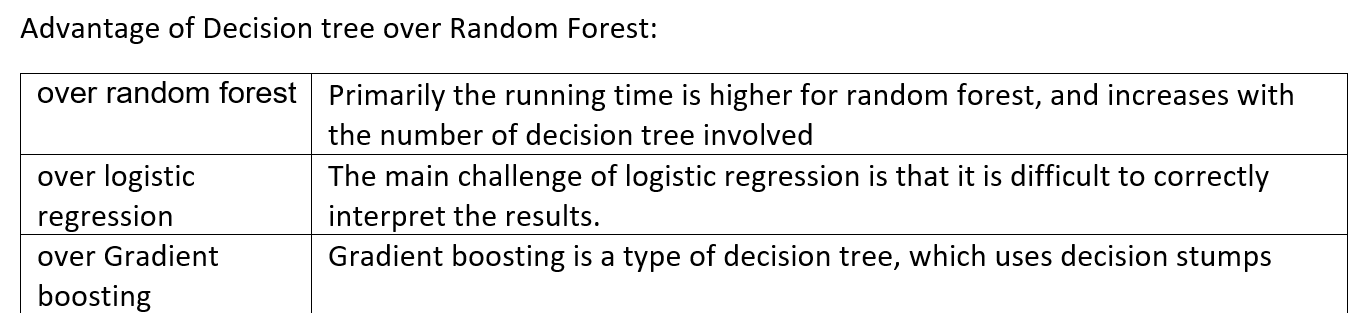

In [361]:
f1 = dtevaluator.evaluate(dtpredictions, {dtevaluator.metricName: "f1"})
Precision = dtevaluator.evaluate(dtpredictions, {dtevaluator.metricName: "weightedPrecision"})
Recall = dtevaluator.evaluate(dtpredictions, {dtevaluator.metricName: "weightedRecall"})
accuracy=dtevaluator.evaluate(dtpredictions)

Model=["Decision Tree Scores with cross validation"]
f1_=[f1]
Precision_=[Precision]
Recall_=[Recall]
cross_val_Score=[cv_sc]
Accuracy=[0.8422]
difference=[0.8422-cv_sc]


scores_decision_tree=pd.DataFrame({'Model': Model, 'Cross validation score':cross_val_Score,'Accuracy without cross validation':Accuracy,'f1 score':f1_,'Average precision score':Precision_,'Recall':Recall})
scores_decision_tree.head(2).transpose()

,0
Model,Decision Tree Scores with cross validation
Cross validation score,0.783627
Accuracy without cross validation,0.8422
f1 score,0.783627
Average precision score,0.788848
Recall,0.851449


# Hyper parameter Tuning of Random Forest

In [363]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

RF= RandomForestClassifier(labelCol='label', featuresCol='features',seed=None)

# Create ParamGrid for Cross Validation
dtparamGrid = (ParamGridBuilder()
         .addGrid(RF.maxDepth, [2, 5, 10])
         .addGrid(RF.impurity, ['gini','entropy'])
         .addGrid(RF.numTrees, [2,3,4])
         .addGrid(RF.impurity, ['gini','entropy'])
         .build())

# Evaluate model
dtevaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Create 5-fold CrossValidator
dtcv = CrossValidator(estimator = RF,
                  estimatorParamMaps = dtparamGrid,
                  evaluator = dtevaluator,
                  numFolds = 5)

# Run cross validations
dtcvModel = dtcv.fit(train)
print(dtcvModel)

# Use test set here so we can measure the accuracy of our model on new  validation Sdata
dtpredictions = dtcvModel.transform(valid)

cv_sc=dtevaluator.evaluate(dtpredictions)
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print('Accuracy with cross validation of Random Forest Classifier:',cv_sc )

CrossValidatorModel_3d8040ca37f9
Accuracy with cross validation of Random Forest Classifier: 0.7835224018217098


In [371]:
f1 = dtevaluator.evaluate(cvPredictions, {cvEvaluator.metricName: "f1"})
Precision = dtevaluator.evaluate(cvPredictions, {cvEvaluator.metricName: "weightedPrecision"})
Recall = dtevaluator.evaluate(cvPredictions, {cvEvaluator.metricName: "weightedRecall"})
accuracy=dtevaluator.evaluate(cvPredictions)

Model=["Random Forest Classifier Scores"]
f1_=[f1]
Precision_=[Precision]
Recall_=[Recall]
cross_val_Score=[cv_sc]
Accuracy=[0.8422]
difference=[0.8422-cv_sc]

scores_RF=pd.DataFrame({'Model': Model, 'Cross validation score':cross_val_Score,'Accuracy without cross validation':Accuracy,'f1 score':f1_,'Average precision score':Precision_,'Recall':Recall})
scores_RF.head(2).transpose()

,0
Model,Random Forest Classifier Scores
Cross validation score,0.783522
Accuracy without cross validation,0.8422
f1 score,0.77453
Average precision score,0.77453
Recall,0.77453


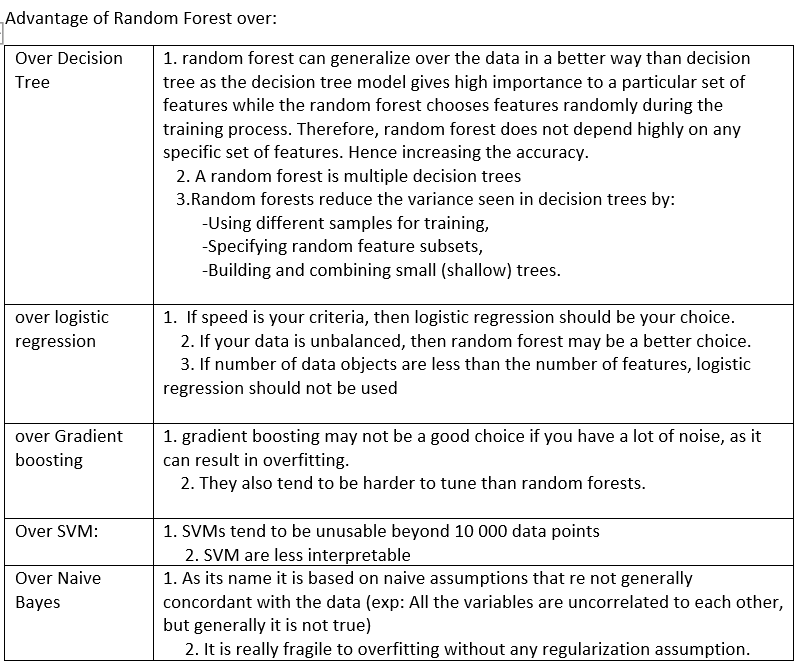

# Hyper parameter Tuning of Gradient Boosting classifier

In [372]:
from pyspark.ml.classification import GBTClassifier
GBC = GBTClassifier(labelCol = 'label', featuresCol = 'features')

GBC.extractParamMap()

{Param(parent='GBTClassifier_28badcd5be4a', name='seed', doc='random seed.'): -7528408124176939278,
 Param(parent='GBTClassifier_28badcd5be4a', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes. Must be in range [0, 30].'): 5,
 Param(parent='GBTClassifier_28badcd5be4a', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 32,
 Param(parent='GBTClassifier_28badcd5be4a', name='minInstancesPerNode', doc='Minimum number of instances each child must have after split. If a split causes the left or right child to have fewer than minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.'): 1,
 Param(parent='GBTClassifier_28badcd5be4a', name='minInfoGain', doc='Minimum information gain for a split to be considered at a tree node.'): 0.0,
 Param(parent='GBTClassifier_28badcd5be4a', name='maxMemoryI

In [373]:

# Create ParamGrid for Cross Validation
dtparamGrid = (ParamGridBuilder()
         .addGrid(GBC.cacheNodeIds, [True,False])
         .addGrid(GBC.maxDepth, [1,2,10,20])
          .addGrid(GBC.maxBins, [2,4,8])
         .addGrid(GBC.maxIter, [1,2,10,20])
         .build())

# Evaluate model
dtevaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Create 5-fold CrossValidator
dtcv = CrossValidator(estimator =GBC,
                  estimatorParamMaps = dtparamGrid,
                  evaluator = dtevaluator,
                  numFolds = 5)

# Run cross validations
dtcvModel = dtcv.fit(train)
print(dtcvModel)

# Use test set here so we can measure the accuracy of our model on new  validation Sdata
dtpredictions = dtcvModel.transform(valid)

cv_sc=dtevaluator.evaluate(dtpredictions)
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print('Accuracy with cross validation of Gradient Boosting Classifier:',cv_sc )


f1 = dtevaluator.evaluate(cvPredictions, {cvEvaluator.metricName: "f1"})
Precision = dtevaluator.evaluate(cvPredictions, {cvEvaluator.metricName: "weightedPrecision"})
Recall = dtevaluator.evaluate(cvPredictions, {cvEvaluator.metricName: "weightedRecall"})
accuracy=dtevaluator.evaluate(cvPredictions)

Model=["Gradient Boosting Scores"]
f1_=[f1]
Precision_=[Precision]
Recall_=[Recall]
cross_val_Score=[cv_sc]
Accuracy=[0.8422]
difference=[0.8422-cv_sc]


scores_GB=pd.DataFrame({'Model': Model, 'Cross validation score':cross_val_Score,'Accuracy without cross validation':Accuracy,'f1 score':f1_,'Average precision score':Precision_,'Recall':Recall})
scores_GB.head(2).transpose()

CrossValidatorModel_807c24c3d862
Accuracy with cross validation of Gradient Boosting Classifier: 0.7832381292564254


,0
Model,Gradient Boosting Scores
Cross validation score,0.783238
Accuracy without cross validation,0.8422
f1 score,0.77453
Average precision score,0.77453
Recall,0.77453


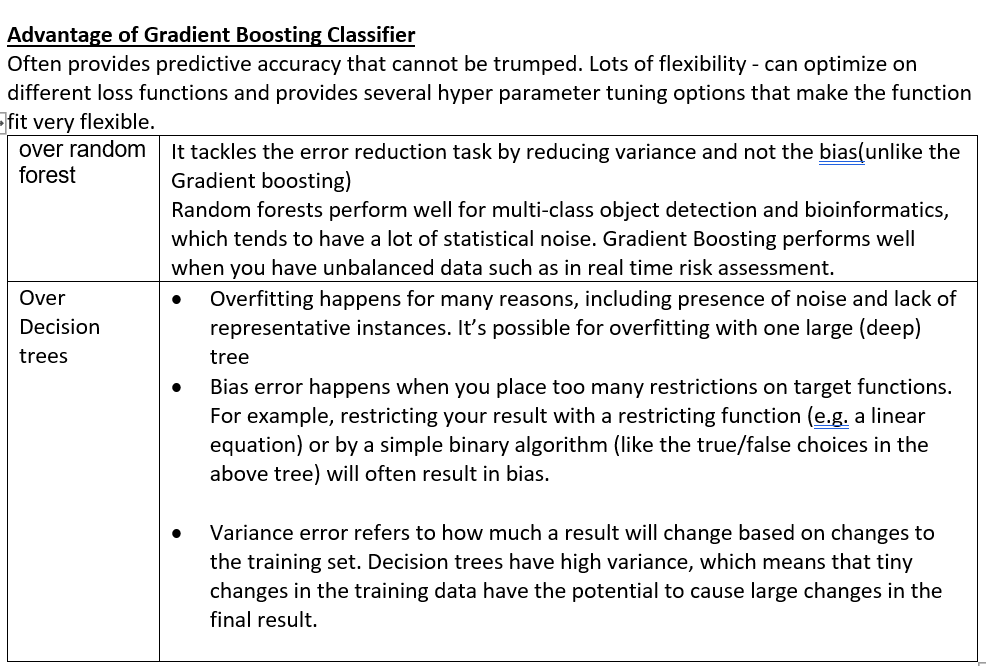

# Hyper parameter Tuning of Naive Bayes Classifier

In [94]:
from pyspark.ml.classification import NaiveBayes
NB = NaiveBayes(featuresCol = 'features', labelCol = 'label')
NB.extractParamMap()

{Param(parent='NaiveBayes_c54a8943a477', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='NaiveBayes_c54a8943a477', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='NaiveBayes_c54a8943a477', name='labelCol', doc='label column name.'): 'label',
 Param(parent='NaiveBayes_c54a8943a477', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name.'): 'rawPrediction',
 Param(parent='NaiveBayes_c54a8943a477', name='smoothing', doc='The smoothing parameter, should be >= 0, default is 1.0'): 1.0,
 Param(parent='NaiveBayes_c54a8943a477', name='modelType', doc='The model type which is a string (case-sensitive). Supported options: multinomial (default), bernoulli and gaussian.'): 'multinomial',
 Param(parent='NaiveBayes_c54a8943a477', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be tre

Hence
1. Since Its differentiating between 0 and 1, we will use the model type binomial
2. smoothing parameter: Smoothing solves the zero probability problem in Naive Bayes algorithm, which is the problem of assigning probability equal to zero for every new data point in the test set.As per documentation it should be >= 0, default is 1.0. Zero probability problem can introduce wrong results when the smoothing technique isn't used well.
3. thresholds: Thresholds in multi-class classification to adjust the probability of predicting each class.

In [95]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import NaiveBayes


nb = NaiveBayes(modelType="multinomial")

# Create ParamGrid and Evaluator for Cross Validation
paramGrid = ParamGridBuilder().addGrid(nb.smoothing, [0.0, 0.2, 0.4, 0.6, 0.8, 1.0,1.2,1.4,1.6,1.8,2]).build()
cvEvaluator =MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='label',metricName='f1')

# Run Cross-validation
cv = CrossValidator(estimator=nb, estimatorParamMaps=paramGrid, evaluator=cvEvaluator)
Naive_Model = cv.fit(train)

# Make predictions on testData. cvModel uses the bestModel.
cvPredictions = Naive_Model.transform(test)

accuracy= cvEvaluator.evaluate(cvPredictions)
f1 = cvEvaluator.evaluate(cvPredictions, {cvEvaluator.metricName: "f1"})
Precision = cvEvaluator.evaluate(cvPredictions, {cvEvaluator.metricName: "weightedPrecision"})
Recall = cvEvaluator.evaluate(cvPredictions, {cvEvaluator.metricName: "weightedRecall"})

f1_=[f1]
Precision_=[Precision]
Recall_=[Recall]
Accuracy=[0.845079]
difference=[0.845079-accuracy]
cross_val_Score=[accuracy]

result=pd.DataFrame({ 'f1 score':f1_,'Average precision score':Precision_,'Recall':Recall_,'Cross validation score':cross_val_Score,'Accuracy':Accuracy,'difference between corss validation score and accuracy':difference})

print("Scores with Hyper parameter tuning\n",result)

In [ ]:
cvPredictions

In [96]:
Naive_Model

CrossValidatorModel_c6236d4610d2

# SELECTING MODEL

The best model selected is Naive Bayes. Reason:
  1. Problem statement demanded ROC Area to be the criteria factor, which shows 0.61 as compared to others which show only 0.5
  2. When assumption of independence holds, a Naive Bayes classifier performs better compare to other models like logistic regression,since less multicollinearity is seen in dataset it is a good model to go forward with
  3. Easy to interpret since they provide a probabilistic prediction
  4. Easy to implement having only a few tunable parameters such as alpha

# SVM

Since SVMs are unstable beyond 10,000 data points. It is not taken into consideration

# Logistic regression

In [377]:
from pyspark.ml.classification import LogisticRegression
LR = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
LR.extractParamMap()

{Param(parent='LogisticRegression_d14baf65e8d1', name='maxBlockSizeInMB', doc='maximum memory in MB for stacking input data into blocks. Data is stacked within partitions. If more than remaining data size in a partition then it is adjusted to the data size. Default 0.0 represents choosing optimal value, depends on specific algorithm. Must be >= 0.'): 0.0,
 Param(parent='LogisticRegression_d14baf65e8d1', name='threshold', doc='Threshold in binary classification prediction, in range [0, 1]. If threshold and thresholds are both set, they must match.e.g. if threshold is p, then thresholds must be equal to [1-p, p].'): 0.5,
 Param(parent='LogisticRegression_d14baf65e8d1', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LogisticRegression_d14baf65e8d1', name='standardization', doc='whether to standardize the training features before fitting the model.'): True,
 Param(parent='LogisticRegression_d14baf65e8d1', name='fitIntercept', doc='whether to fi

In [378]:
# Create ParamGrid for Cross Validation
dtparamGrid = (ParamGridBuilder()
         .addGrid(LR.threshold, [0.2, 0.4, 0.7])
         .addGrid(LR.aggregationDepth, [2,4,8])
         .addGrid(LR.standardization, [True,False])
         .addGrid(LR.elasticNetParam, [0,1])
         .build())

# Evaluate model
dtevaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Create 5-fold CrossValidator
dtcv = CrossValidator(estimator = LR,
                  estimatorParamMaps = dtparamGrid,
                  evaluator = dtevaluator,
                  numFolds = 5)

# Run cross validations
dtcvModel = dtcv.fit(train)
print(dtcvModel)

# Use test set here so we can measure the accuracy of our model on new  validation Sdata
dtpredictions = dtcvModel.transform(valid)

cv_sc=dtevaluator.evaluate(dtpredictions)
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
print('Accuracy with cross validation of Logisitc Regression:',cv_sc )


f1 = dtevaluator.evaluate(dtpredictions, {dtevaluator.metricName: "f1"})
Precision = dtevaluator.evaluate(dtpredictions, {dtevaluator.metricName: "weightedPrecision"})
Recall = dtevaluator.evaluate(dtpredictions, {dtevaluator.metricName: "weightedRecall"})
accuracy=dtevaluator.evaluate(dtpredictions)

Model=["LogisticRegression Scores"]
f1_=[f1]
Precision_=[Precision]
Recall_=[Recall]
cross_val_Score=[cv_sc]
Accuracy=[0.845079]
difference=[0.845079-cv_sc]


scores=pd.DataFrame({'Model': Model, 'f1 score':f1_,'Average precision score':Precision_,'Recall':Recall_,'Cross validation score':cross_val_Score,'Accuracy':Accuracy,'difference between corss validation score and accuracy':difference})

CrossValidatorModel_e633ffff276c
Accuracy with cross validation of Logisitc Regression: 0.7832381292564254


In [381]:
scores.head(2).transpose()

,0
Model,LogisticRegression Scores
f1 score,0.783238
Average precision score,0.725092
Recall,0.851523
Cross validation score,0.783238
Accuracy,0.845079
difference between corss validation score and accuracy,0.061841


## PREDICTING WITH THE NEW DATASET

In [97]:
## read the dataset
df=spark.read.option('header','true').csv('test.csv',inferSchema=True)

In [98]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Region_Code: string (nullable = true)
 |-- Occupation: string (nullable = true)
 |-- Channel_Code: string (nullable = true)
 |-- Vintage: integer (nullable = true)
 |-- Credit_Product: string (nullable = true)
 |-- Avg_Account_Balance: integer (nullable = true)
 |-- Is_Active: string (nullable = true)



# Data Preprocessing of Test data

In [99]:
from pyspark.sql import functions as f
from pyspark.sql.types import IntegerType
import numpy as np
from pyspark.sql import functions as F
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler

#df = df.drop("ID")
cat_cols=[x for (x,dataType) in df.dtypes if dataType == "string"]
num_cols=[x for (x,dataType) in df.dtypes if ((dataType == 'double') & (x!='Is_Lead'))]

for column in num_cols:
    df = df.withColumn(column,f.col(column).cast(IntegerType()))
    
numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

In [100]:
for col in df.columns:
    print(col+":",df[df[col].isNull()].count())

ID: 0
Gender: 0
Age: 0
Region_Code: 0
Occupation: 0
Channel_Code: 0
Vintage: 0
Credit_Product: 11362
Avg_Account_Balance: 0
Is_Active: 0


In [101]:
#dropping rows of null values
print("number of rows before dropping null values",df.count())
df=df.na.drop()
print("number of rows after dropping null values",df.count())

number of rows before dropping null values 95726
number of rows after dropping null values 84364


In [102]:
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+---+------+---+-----------+----------+------------+-------+--------------+-------------------+---------+
| ID|Gender|Age|Region_Code|Occupation|Channel_Code|Vintage|Credit_Product|Avg_Account_Balance|Is_Active|
+---+------+---+-----------+----------+------------+-------+--------------+-------------------+---------+
|  0|     0|  0|          0|         0|           0|      0|             0|                  0|        0|
+---+------+---+-----------+----------+------------+-------+--------------+-------------------+---------+



In [103]:
print("number of rows before dropping duplicate values",df.count())
df=df.dropDuplicates()
print("number of rows after dropping duplicate values",df.count())

number of rows before dropping duplicate values 84364
number of rows after dropping duplicate values 84364


In [104]:
df.show(2)

+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+
|      ID|Gender|Age|Region_Code|   Occupation|Channel_Code|Vintage|Credit_Product|Avg_Account_Balance|Is_Active|
+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+
|BNMV4GMG|  Male| 29|      RG271|     Salaried|          X1|     25|           Yes|             883387|       No|
|BJNLQDIT|  Male| 54|      RG268|Self_Employed|          X3|     98|           Yes|            1605355|       No|
+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+
only showing top 2 rows



In [106]:
def find_outliers(df):

    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol,f.when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]

    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',sum(df[column] for column in selected_columns))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

new_df = find_outliers(df)

new_df_with_no_outliers = new_df.filter(new_df['total_Outliers']<=1)
new_df_with_no_outliers = new_df_with_no_outliers.select(*df.columns)

df=new_df_with_no_outliers

df.show(2)

+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+
|      ID|Gender|Age|Region_Code|   Occupation|Channel_Code|Vintage|Credit_Product|Avg_Account_Balance|Is_Active|
+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+
|BNMV4GMG|  Male| 29|      RG271|     Salaried|          X1|     25|           Yes|             883387|       No|
|BJNLQDIT|  Male| 54|      RG268|Self_Employed|          X3|     98|           Yes|            1605355|       No|
+--------+------+---+-----------+-------------+------------+-------+--------------+-------------------+---------+
only showing top 2 rows



In [107]:
from pyspark.ml.feature import (OneHotEncoder,StringIndexer)
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col, explode, array, lit

cat_cols=['Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active']
num_cols=['Age','Vintage','Avg_Account_Balance']

string_indexer = [
    StringIndexer(inputCol=i, outputCol=i + "_StringIndexer", handleInvalid="skip")
    for i in cat_cols
]

one_hot_encoder = [
    OneHotEncoder(
        inputCols=[f"{i}_StringIndexer" for i in cat_cols],
        outputCols=[f"{i}_OneHotEncoder" for i in cat_cols],
    )
]

assemblerInput = [x for x in num_cols]
assemblerInput += [f"{i}_OneHotEncoder" for i in cat_cols]
vector_assembler = VectorAssembler(inputCols=assemblerInput, outputCol="One_hot_encoded_features")

stages = []
stages += string_indexer
stages += one_hot_encoder
stages += [vector_assembler]
stages

%%time
from pyspark.ml import Pipeline

pipeline = Pipeline().setStages(stages)
model = pipeline.fit(df)

pp_df = model.transform(df)
df=pp_df
df_pyspark_withoutcat = df.drop('Gender','Region_Code','Occupation','Channel_Code','Credit_Product','Is_Active')
df=df_pyspark_withoutcat

assembler1 = VectorAssembler(inputCols=df.columns[1:],outputCol="features")
outdata1 = assembler1.transform(df)
df=outdata1


UsageError: Line magic function `%%time` not found.


In [108]:


from pyspark.ml.feature import VectorAssembler, StandardScaler

df=df.drop('Avg_Account_Balance')
num_cols=['Age','Vintage']

#assembling the numerical features together to perform standardisation
vector_assembler = VectorAssembler(inputCols=num_cols, outputCol="num_features_vector",)
df = vector_assembler.transform(df)

#perform standardisation
standard_scaler = StandardScaler(inputCol="num_features_vector", outputCol="scaled",withStd=True, withMean=False)
df= standard_scaler.fit(df).transform(df)

assembler = VectorAssembler(inputCols=['scaled','num_features_vector'], outputCol="final_features")
data = assembler.transform(df)
df=data

df.show(2)

+--------+------+---+-----------+-------------+------------+-------+--------------+---------+-------------------+--------------------+--------------------+
|      ID|Gender|Age|Region_Code|   Occupation|Channel_Code|Vintage|Credit_Product|Is_Active|num_features_vector|              scaled|      final_features|
+--------+------+---+-----------+-------------+------------+-------+--------------+---------+-------------------+--------------------+--------------------+
|BNMV4GMG|  Male| 29|      RG271|     Salaried|          X1|     25|           Yes|       No|        [29.0,25.0]|[1.95589814754759...|[1.95589814754759...|
|BJNLQDIT|  Male| 54|      RG268|Self_Employed|          X3|     98|           Yes|       No|        [54.0,98.0]|[3.64201724026104...|[3.64201724026104...|
+--------+------+---+-----------+-------------+------------+-------+--------------+---------+-------------------+--------------------+--------------------+
only showing top 2 rows



In [109]:
df=df.withColumnRenamed("final_features","features")

In [110]:
final_results = Naive_Model.transform(df)

In [111]:
final_results.show(2)

+--------+------+---+-----------+-------------+------------+-------+--------------+---------+-------------------+--------------------+--------------------+--------------------+--------------------+----------+
|      ID|Gender|Age|Region_Code|   Occupation|Channel_Code|Vintage|Credit_Product|Is_Active|num_features_vector|              scaled|            features|       rawPrediction|         probability|prediction|
+--------+------+---+-----------+-------------+------------+-------+--------------+---------+-------------------+--------------------+--------------------+--------------------+--------------------+----------+
|BNMV4GMG|  Male| 29|      RG271|     Salaried|          X1|     25|           Yes|       No|        [29.0,25.0]|[1.95589814754759...|[1.95589814754759...|[-50.268635090793...|[0.92528481926785...|       0.0|
|BJNLQDIT|  Male| 54|      RG268|Self_Employed|          X3|     98|           Yes|       No|        [54.0,98.0]|[3.64201724026104...|[3.64201724026104...|[-138.763

In [112]:
final_result_=final_results.select('ID','probability')

In [113]:
import pandas
final_result_.toPandas().to_excel('Test_Output_probabilities.xlsx', sheet_name = 'Sheet1', index = False)